In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from colorama import Fore, Style
import os
import datetime
import pickle
import warnings
from scipy.stats import mannwhitneyu
import scipy.special

from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, SplineTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, BaggingClassifier, HistGradientBoostingClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import log_loss, accuracy_score
from sklearn.calibration import CalibrationDisplay

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBClassifier

import xgboost as xgb




In [5]:
train = pd.read_csv('train.csv', index_col='id')
test = pd.read_csv('test.csv', index_col='id')
original = pd.read_csv('data.csv', delimiter=';')

initial_features = list(test.columns)
test.head()

Marital status  Application mode  Application order  Course  \
id                                                                   
76518               1                 1                  1    9500   
76519               1                 1                  1    9238   
76520               1                 1                  1    9238   
76521               1                44                  1    9147   
76522               1                39                  1    9670   

       Daytime/evening attendance  Previous qualification  \
id                                                          
76518                           1                       1   
76519                           1                       1   
76520                           1                       1   
76521                           1                      39   
76522                           1                       1   

       Previous qualification (grade)  Nacionality  Mother's qualification  \
id                                                                           
76518                           141.0            1                       3   
76519                           128.0            1                       1   
76520                           118.0            1                       1   
76521                           130.0            1                       1   
76522                           110.0            1                       1   

       Father's qualification  ...  \
id                             ...   
76518                       1  ...   
76519                      19  ...   
76520                      19  ...   
76521                      19  ...   
76522                      37  ...   

       Curricular units 1st sem (without evaluations)  \
id                                                      
76518                                               0   
76519                                               0   
76520                                               0   
76521                                               0   
76522                                               0   

       Curricular units 2nd sem (credited)  \
id                                           
76518                                    0   
76519                                    0   
76520                                    0   
76521                                    3   
76522                                    0   

       Curricular units 2nd sem (enrolled)  \
id                                           
76518                                    8   
76519                                    6   
76520                                    6   
76521                                    8   
76522                                    6   

       Curricular units 2nd sem (evaluations)  \
id                                              
76518                                       0   
76519                                       6   
76520                                      11   
76521                                      14   
76522                                       9   

       Curricular units 2nd sem (approved)  Curricular units 2nd sem (grade)  \
id                                                                             
76518                                    0                          0.000000   
76519                                    6                         13.500000   
76520                                    5                         11.000000   
76521                                    5                         11.000000   
76522                                    4                         10.666667   

       Curricular units 2nd sem (without evaluations)  Unemployment rate  \
id                                                                         
76518                                               0               13.9   
76519                                               0               11.1   
76520              

In [237]:
train = pd.concat([train, original])

# Target distribution

There are three target classes: we have a multiclass classification task. The classes are not severely unbalanced.

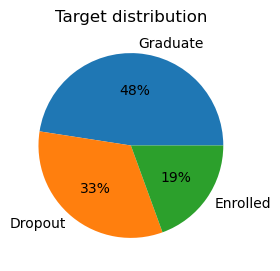

In [238]:
counts = train.Target.value_counts()
counts

plt.figure(figsize=(6, 3))
plt.pie(counts, labels=counts.index, autopct="%.0f%%")
plt.title('Target distribution')
plt.show()

In [239]:
label_encoder = LabelEncoder()
targets = label_encoder.fit_transform(train.Target)
original_targets = label_encoder.transform(original.Target)

# Feature distributions

Based on the [variables table](https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success), some features are categorical. We cannot distinguish categorical features from integer features by looking at the data. We can only distinguish them by looking at the documentation!


In [240]:
[x for x in original.columns if x not in test.columns]

['Target']

In [241]:
original = original.rename(columns={'Daytime/evening attendance\t':'Daytime/evening attendance'})

In [242]:
multi_cat = ['Marital status', 'Application mode', 'Course', 
                'Previous qualification', 'Nacionality', "Mother's qualification", 
                "Father's qualification", "Mother's occupation",
                "Father's occupation"]

bi_cat = ['Daytime/evening attendance', 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 
           'International']

In [243]:
cat = multi_cat+bi_cat

# Applying the Data Dictionary


In [244]:
data_dic = pd.read_excel('Data Dictionary.xlsx')

In [245]:
data_dic.loc[data_dic['Variable Name']=='Marital Status', ['Variable Name']] = 'Marital status'

In [246]:
nums = list(range(0, 9999))

In [247]:
data_dic = data_dic[data_dic['Variable Name'].isin(cat)]

In [248]:
data_dic.Description = data_dic.Description.str.strip()
data_dic.Description = data_dic.Description.str.replace('\'','')
data_dic.Description = data_dic.Description.str.replace(';','')
data_dic.Description = data_dic.Description.str.replace(',',';')

In [249]:
for x in nums:
    data_dic.Description = data_dic.Description.str.replace(' '+str(x)+' - ',', '+str(x)+':')
for x in nums:
    data_dic.Description = data_dic.Description.str.replace(' '+str(x)+' – ',', '+str(x)+':')

In [250]:
data_dic.Description = data_dic.Description.str.replace('1 - ','1:')
data_dic.Description = data_dic.Description.str.replace('1 – ','1:')

In [251]:
data_dic.Description = data_dic.Description.str.replace('0 - ','0:')
data_dic.Description = data_dic.Description.str.replace('0 – ','0:')
data_dic.Description = data_dic.Description.str.replace('33 - ','1:')
data_dic.Description = data_dic.Description.str.replace('33 – ','1:')

In [252]:
data_dic.Description = data_dic.Description + ', 222'

In [253]:
data_dic.Description = data_dic.Description.str.replace(':(.*?),',r':\'\1\',',regex=True)

In [254]:
data_dic.Description = '{'+ data_dic.Description + '}'

In [255]:
data_dic.Description = data_dic.Description.str.replace('\\','')

In [256]:
data_dic.Description = data_dic.Description.str.replace(';',',')

In [257]:
#data_dic.loc[data_dic['Variable Name']=='Father\'s Occupation',['Description']] = "{0:'Student', 1:'Representatives of the Legislative Power and Executive Bodies, Directors, Directors and Executive Managers', 2:'Specialists in Intellectual and Scientific Activities', 3:'Intermediate Level Technicians and Professions', 4:'Administrative staff', 5:'Personal Services, Security and Safety Workers and Sellers', 6:'Farmers and Skilled Workers in Agriculture, Fisheries and Forestry', 7:'Skilled Workers in Industry, Construction and Craftsmen', 8:'Installation and Machine Operators and Assembly Workers', 9:'Unskilled Workers', 10:'Armed Forces Professions', 90:'Other Situation', 99:'(blank)', 122:'Health professionals', 123:'teachers', 125:'Specialists in information and communication technologies (ICT)', 131:'Intermediate level science and engineering technicians and professions', 132:'Technicians and professionals, of intermediate level of health', 134:'Intermediate level technicians from legal, social, sports, cultural and similar services', 141:'Office workers, secretaries in general and data processing operators', 143:'Data, accounting, statistical, financial services and registry-related operators', 144:'Other administrative support staff', 151:'personal service workers', 152:'sellers', 153:'Personal care workers and the like', 171:'Skilled construction workers and the like, except electricians', 173:'Skilled workers in printing, precision instrument manufacturing, jewelers, artisans and the like', 175:'Workers in food processing, woodworking, clothing and other industries and crafts', 191:'cleaning workers', 192:'Unskilled workers in agriculture, animal production, fisheries and forestry', 193:'Unskilled workers in extractive industry, construction, manufacturing and transport', 194:'Meal preparation assistants'}"

In [258]:
#data_dic.loc[data_dic['Variable Name']=='Mother\'s Occupation',['Description']] = data_dic.loc[data_dic['Variable Name']=='Father\'s Occupation',['Description']]

In [259]:
data_dic.Description = data_dic.Description.replace(', 222','', regex=True)

In [260]:
#{33:'Biofuel Production Technologies', 171:'Animation and Multimedia Design', 8014:'Social Service (evening attendance)', 9003:'Agronomy 9070:Communication Design', 9085:'Veterinary Nursing', 9119:'Informatics Engineering', 9130:'Equinculture', 9147:'Management', 9238:'Social Service', 9254:'Tourism', 9500:'Nursing', 9556:'Oral Hygiene', 9670:'Advertising and Marketing Management', 9773:'Journalism and Communication', 9853:'Basic Education', 9991:'Management (evening attendance)'

In [261]:
ttrain = train.copy()

for col in multi_cat:
    #print(col)
    ttrain[col] = ttrain[col].map(eval(data_dic.loc[data_dic['Variable Name']==col, ['Description']].values.tolist()[0][0]))

one_hot_encoded_data = pd.get_dummies(ttrain, columns = multi_cat)

dummy_vars = one_hot_encoded_data.columns.tolist()[28:]

In [262]:
len(dummy_vars)

219

In [263]:
ls = []
for col in dummy_vars:
    data = one_hot_encoded_data.loc[one_hot_encoded_data[col]==1, [col]]
    if data.shape[0]>=100:
        ls.append(col)

In [264]:
len(ls)

92

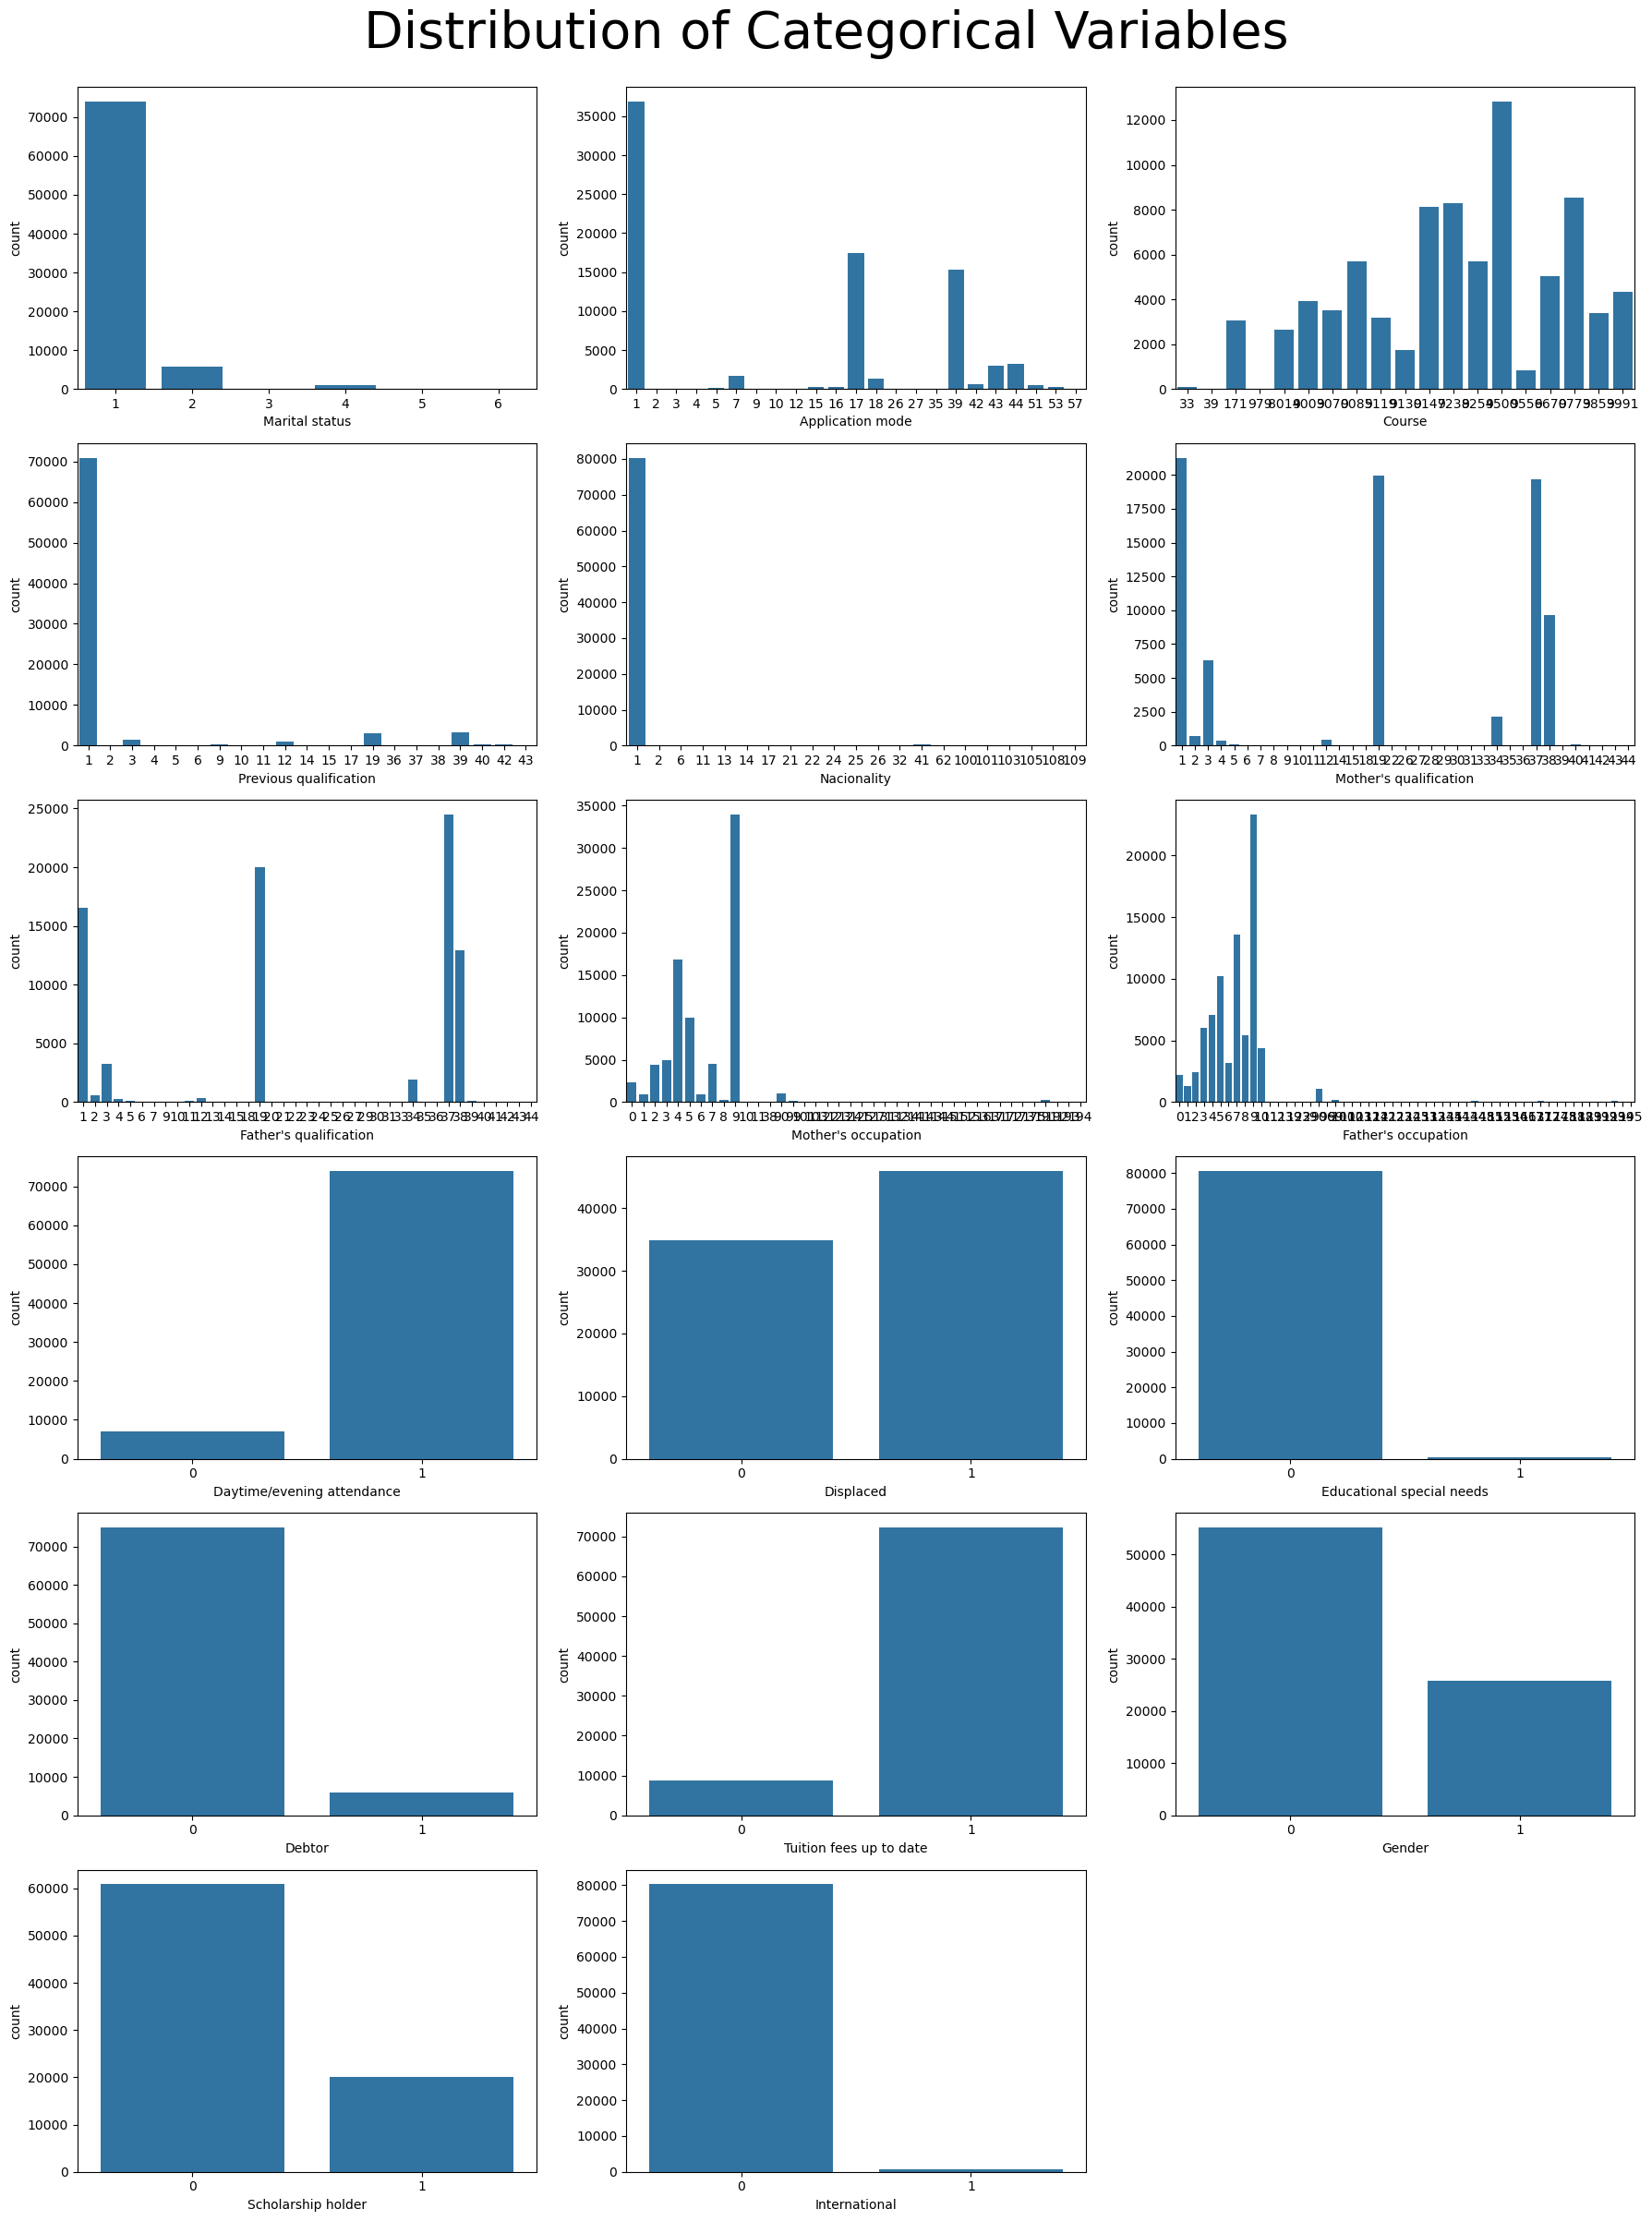

In [265]:
plt.figure(figsize=(18, 24))
plotnumber = 1

# Loop through each column
for col in cat:
    if plotnumber <= len(cat):
        plt.subplot(6, 3, plotnumber)
        ax = sns.countplot(x=train[col])
        
    plotnumber += 1

plt.suptitle('Distribution of Categorical Variables', fontsize=40, y=1)
plt.tight_layout()
plt.show()

In [266]:
num_cols = [col for col in train.columns if train[col].nunique() >= 9]

In [267]:
num_cols = [col for col in num_cols if col not in cat]

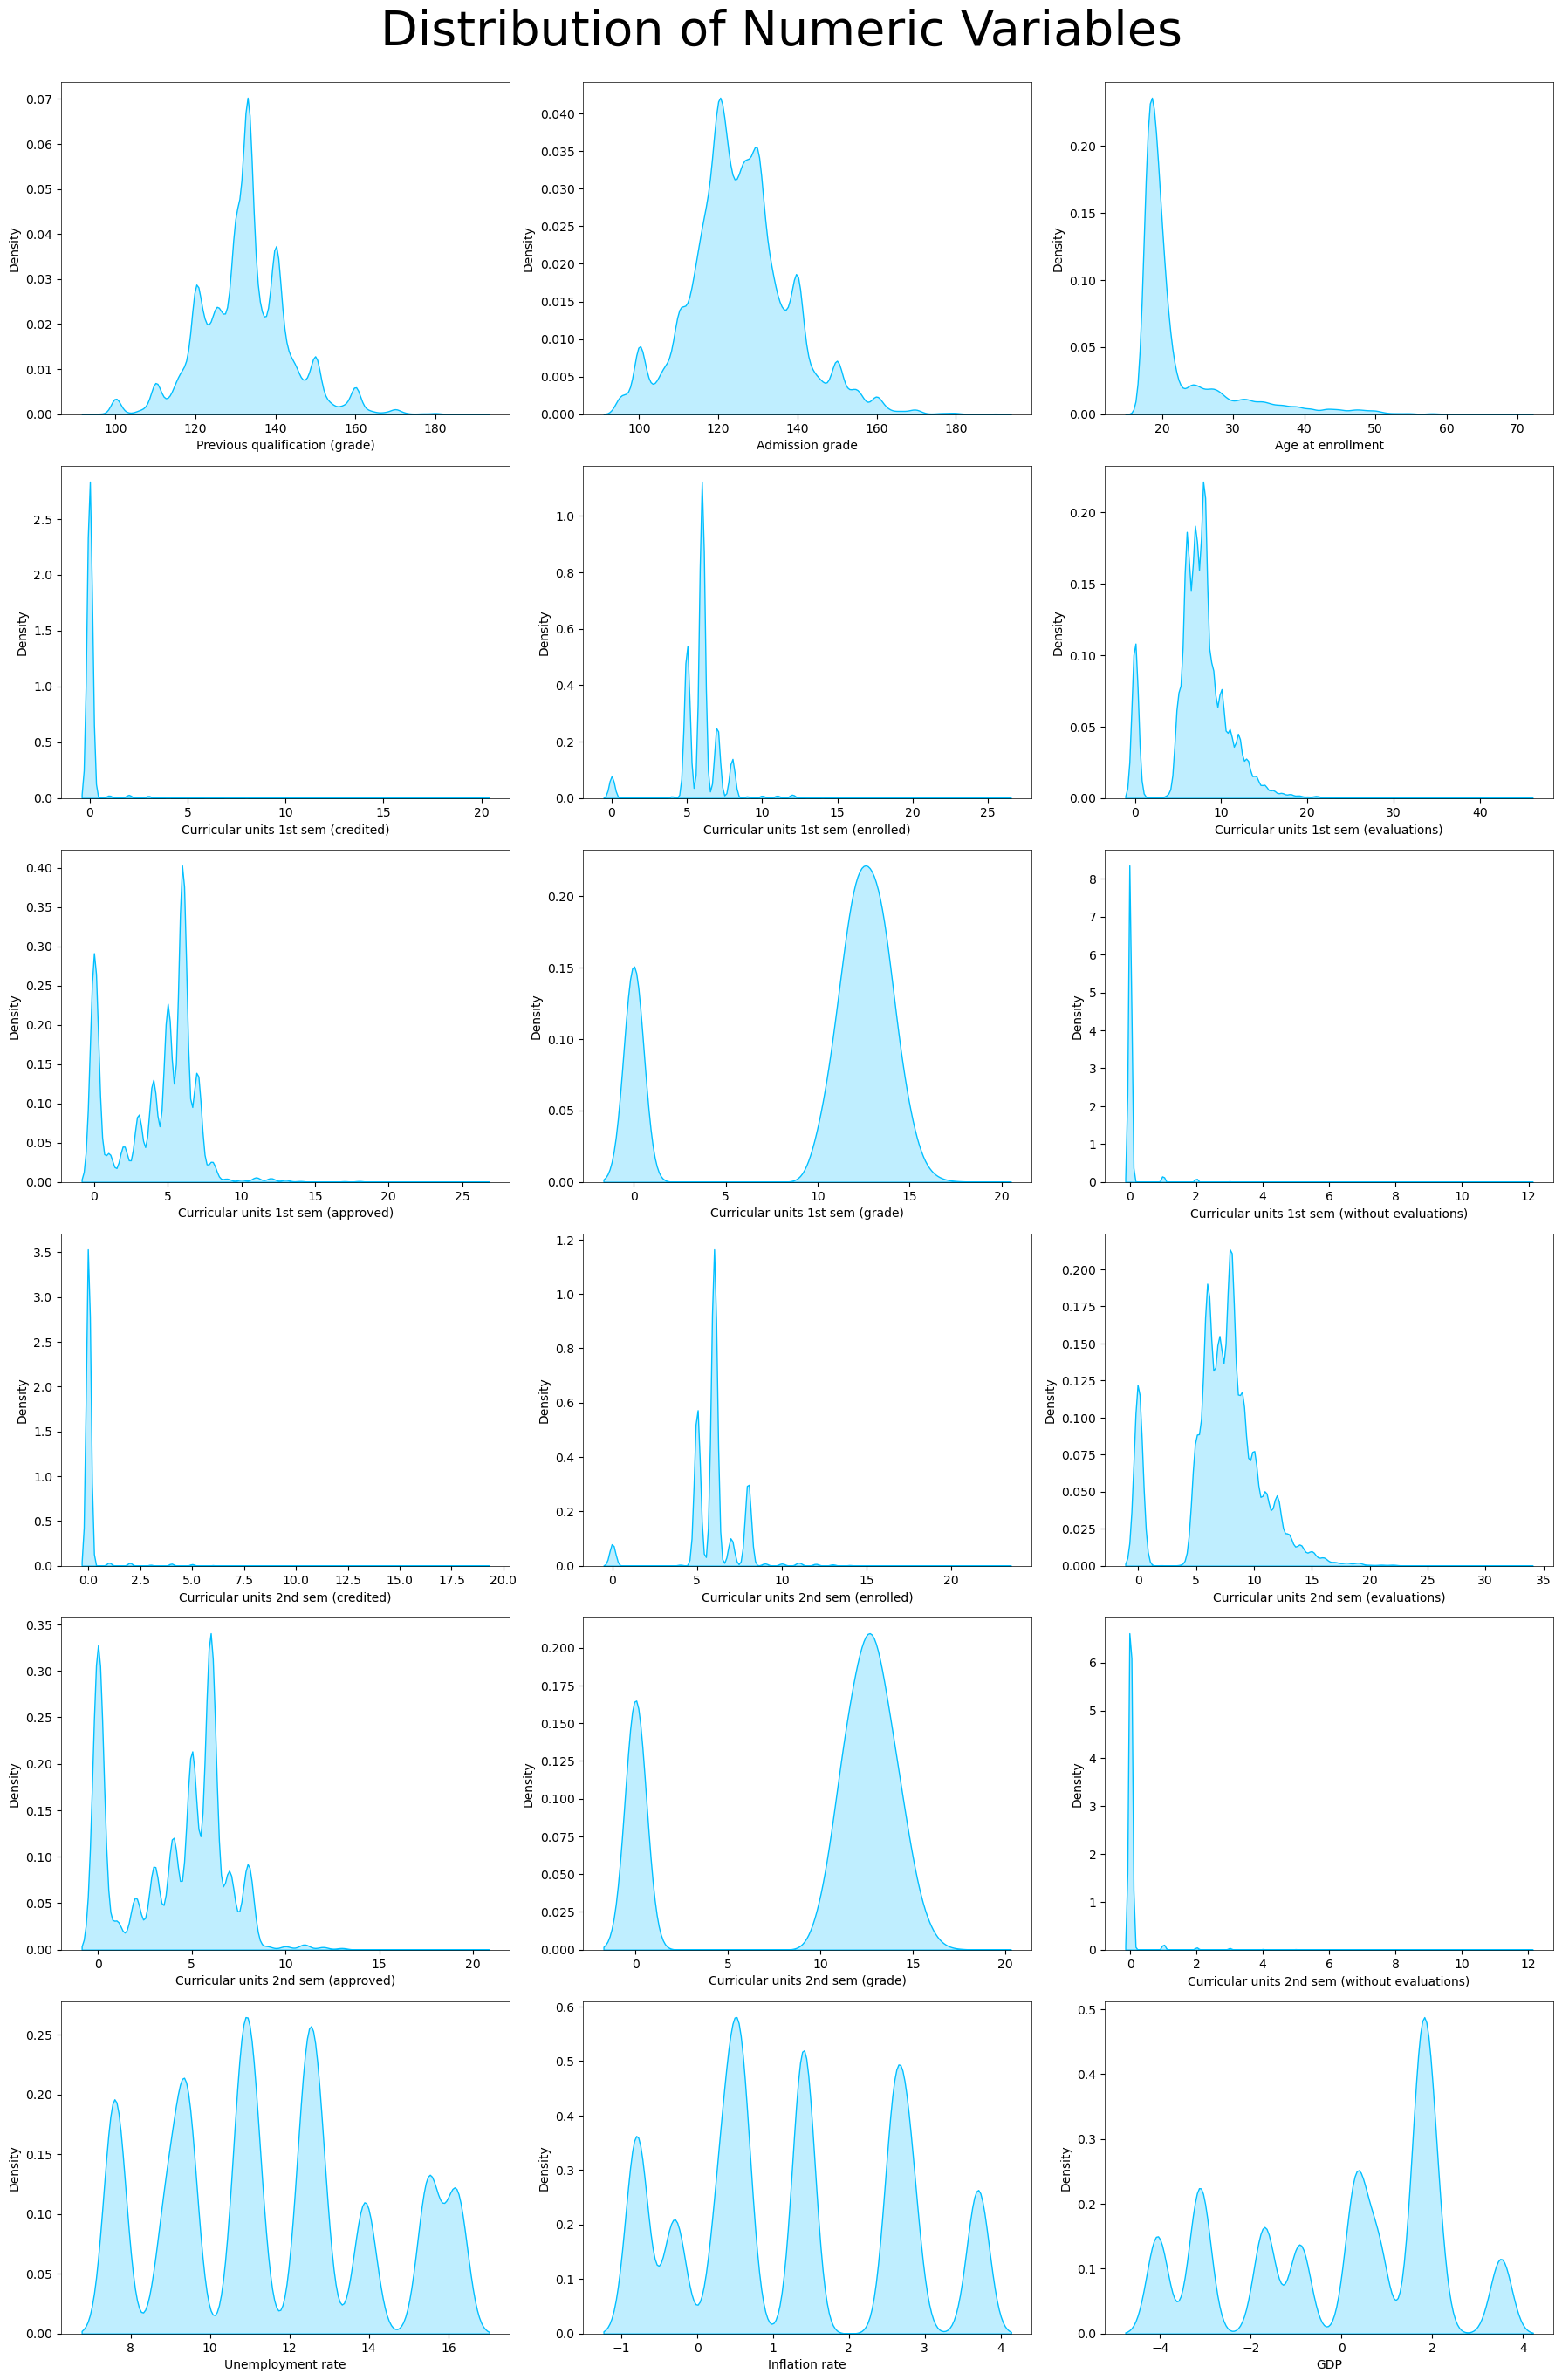

In [268]:
# Distribution of numeric variables
plt.figure(figsize=(18, 40))
plotnumber = 1

for column in num_cols:
    if plotnumber <= len(num_cols):
        ax = plt.subplot(9, 3, plotnumber)
        sns.kdeplot(train[column], color='deepskyblue', fill=True)
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_color('black')
            spine.set_linewidth(0.5)
        plt.xlabel(column)
        ax.grid(False)
        
    plotnumber += 1

plt.suptitle('Distribution of Numeric Variables', fontsize=40, y=1)
plt.tight_layout()
plt.show()

# Exploring differences based on class


In [269]:
palette ={"Graduate": "C0", "Dropout": "C1", "Enrolled": "C2"}

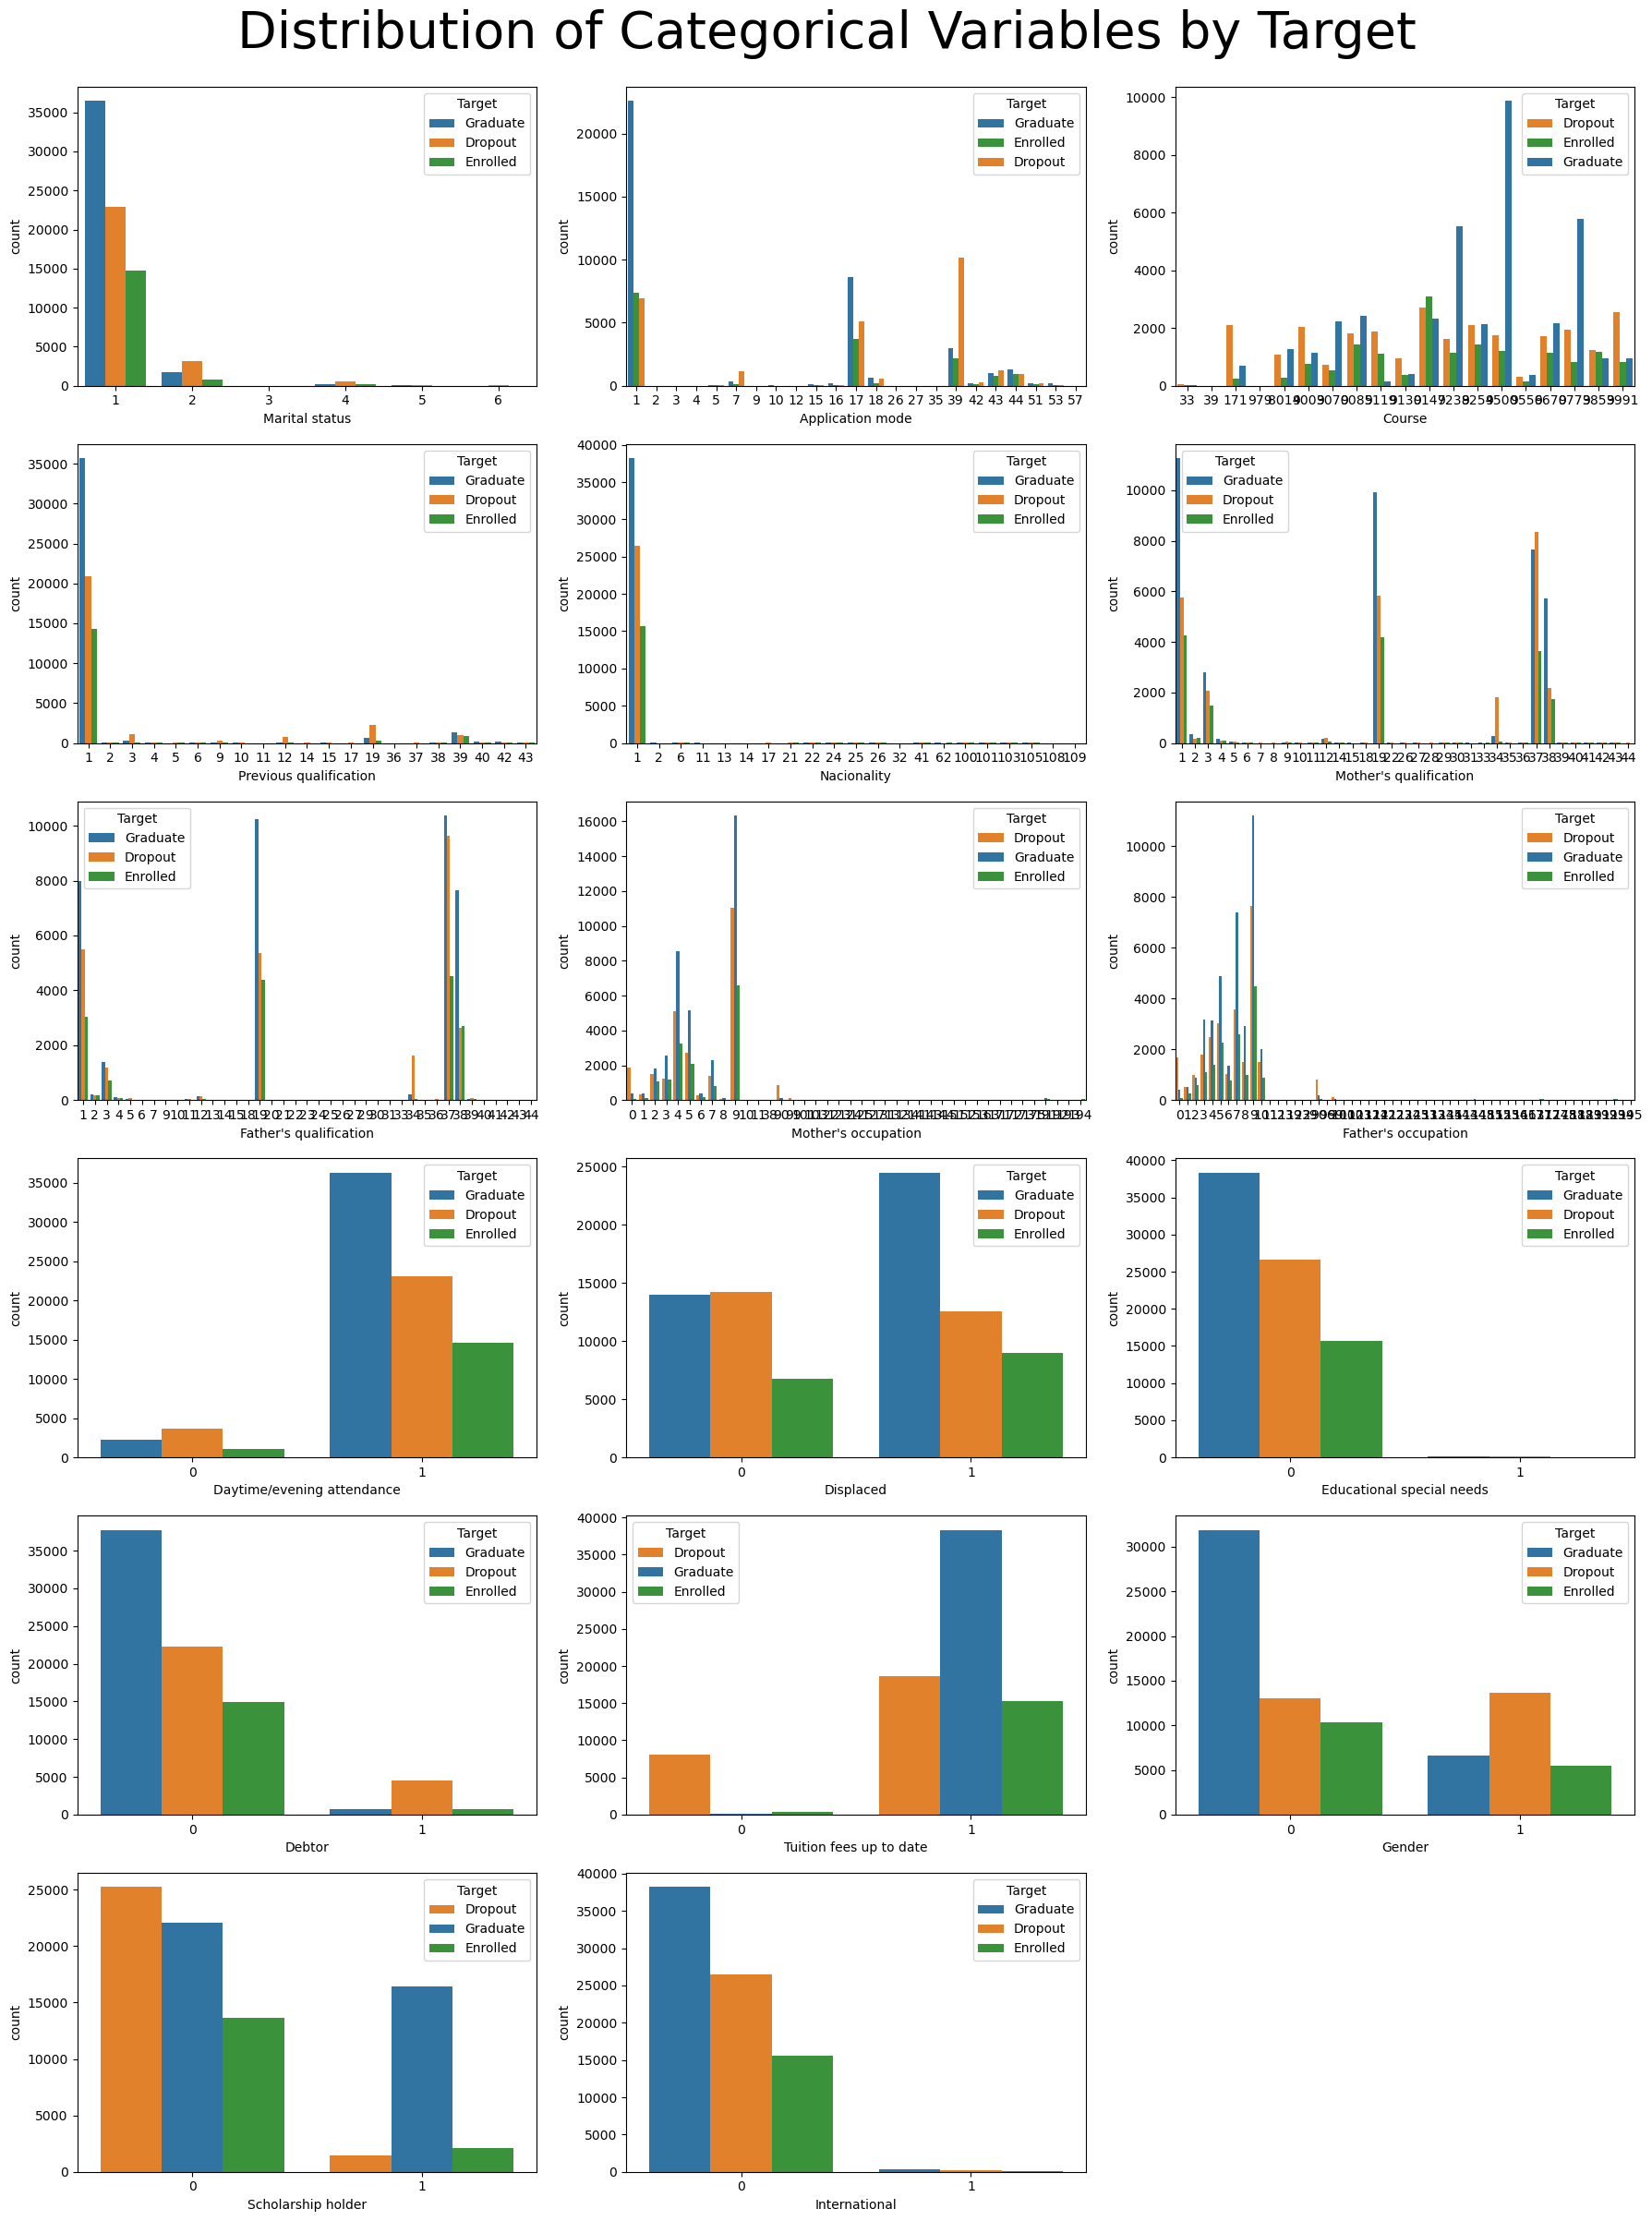

In [270]:
plt.figure(figsize=(18, 24))
plotnumber = 1

# Loop through each column
for col in cat:
    if plotnumber <= len(cat):
        plt.subplot(6, 3, plotnumber)
        ax = sns.countplot(x=train[col], hue=train['Target'], palette=palette)
        
    plotnumber += 1

plt.suptitle('Distribution of Categorical Variables by Target', fontsize=40, y=1)
plt.tight_layout()
plt.show()

In [271]:
palette ={"Graduate": "C0", "Dropout": "C1", "Enrolled": "C2"}

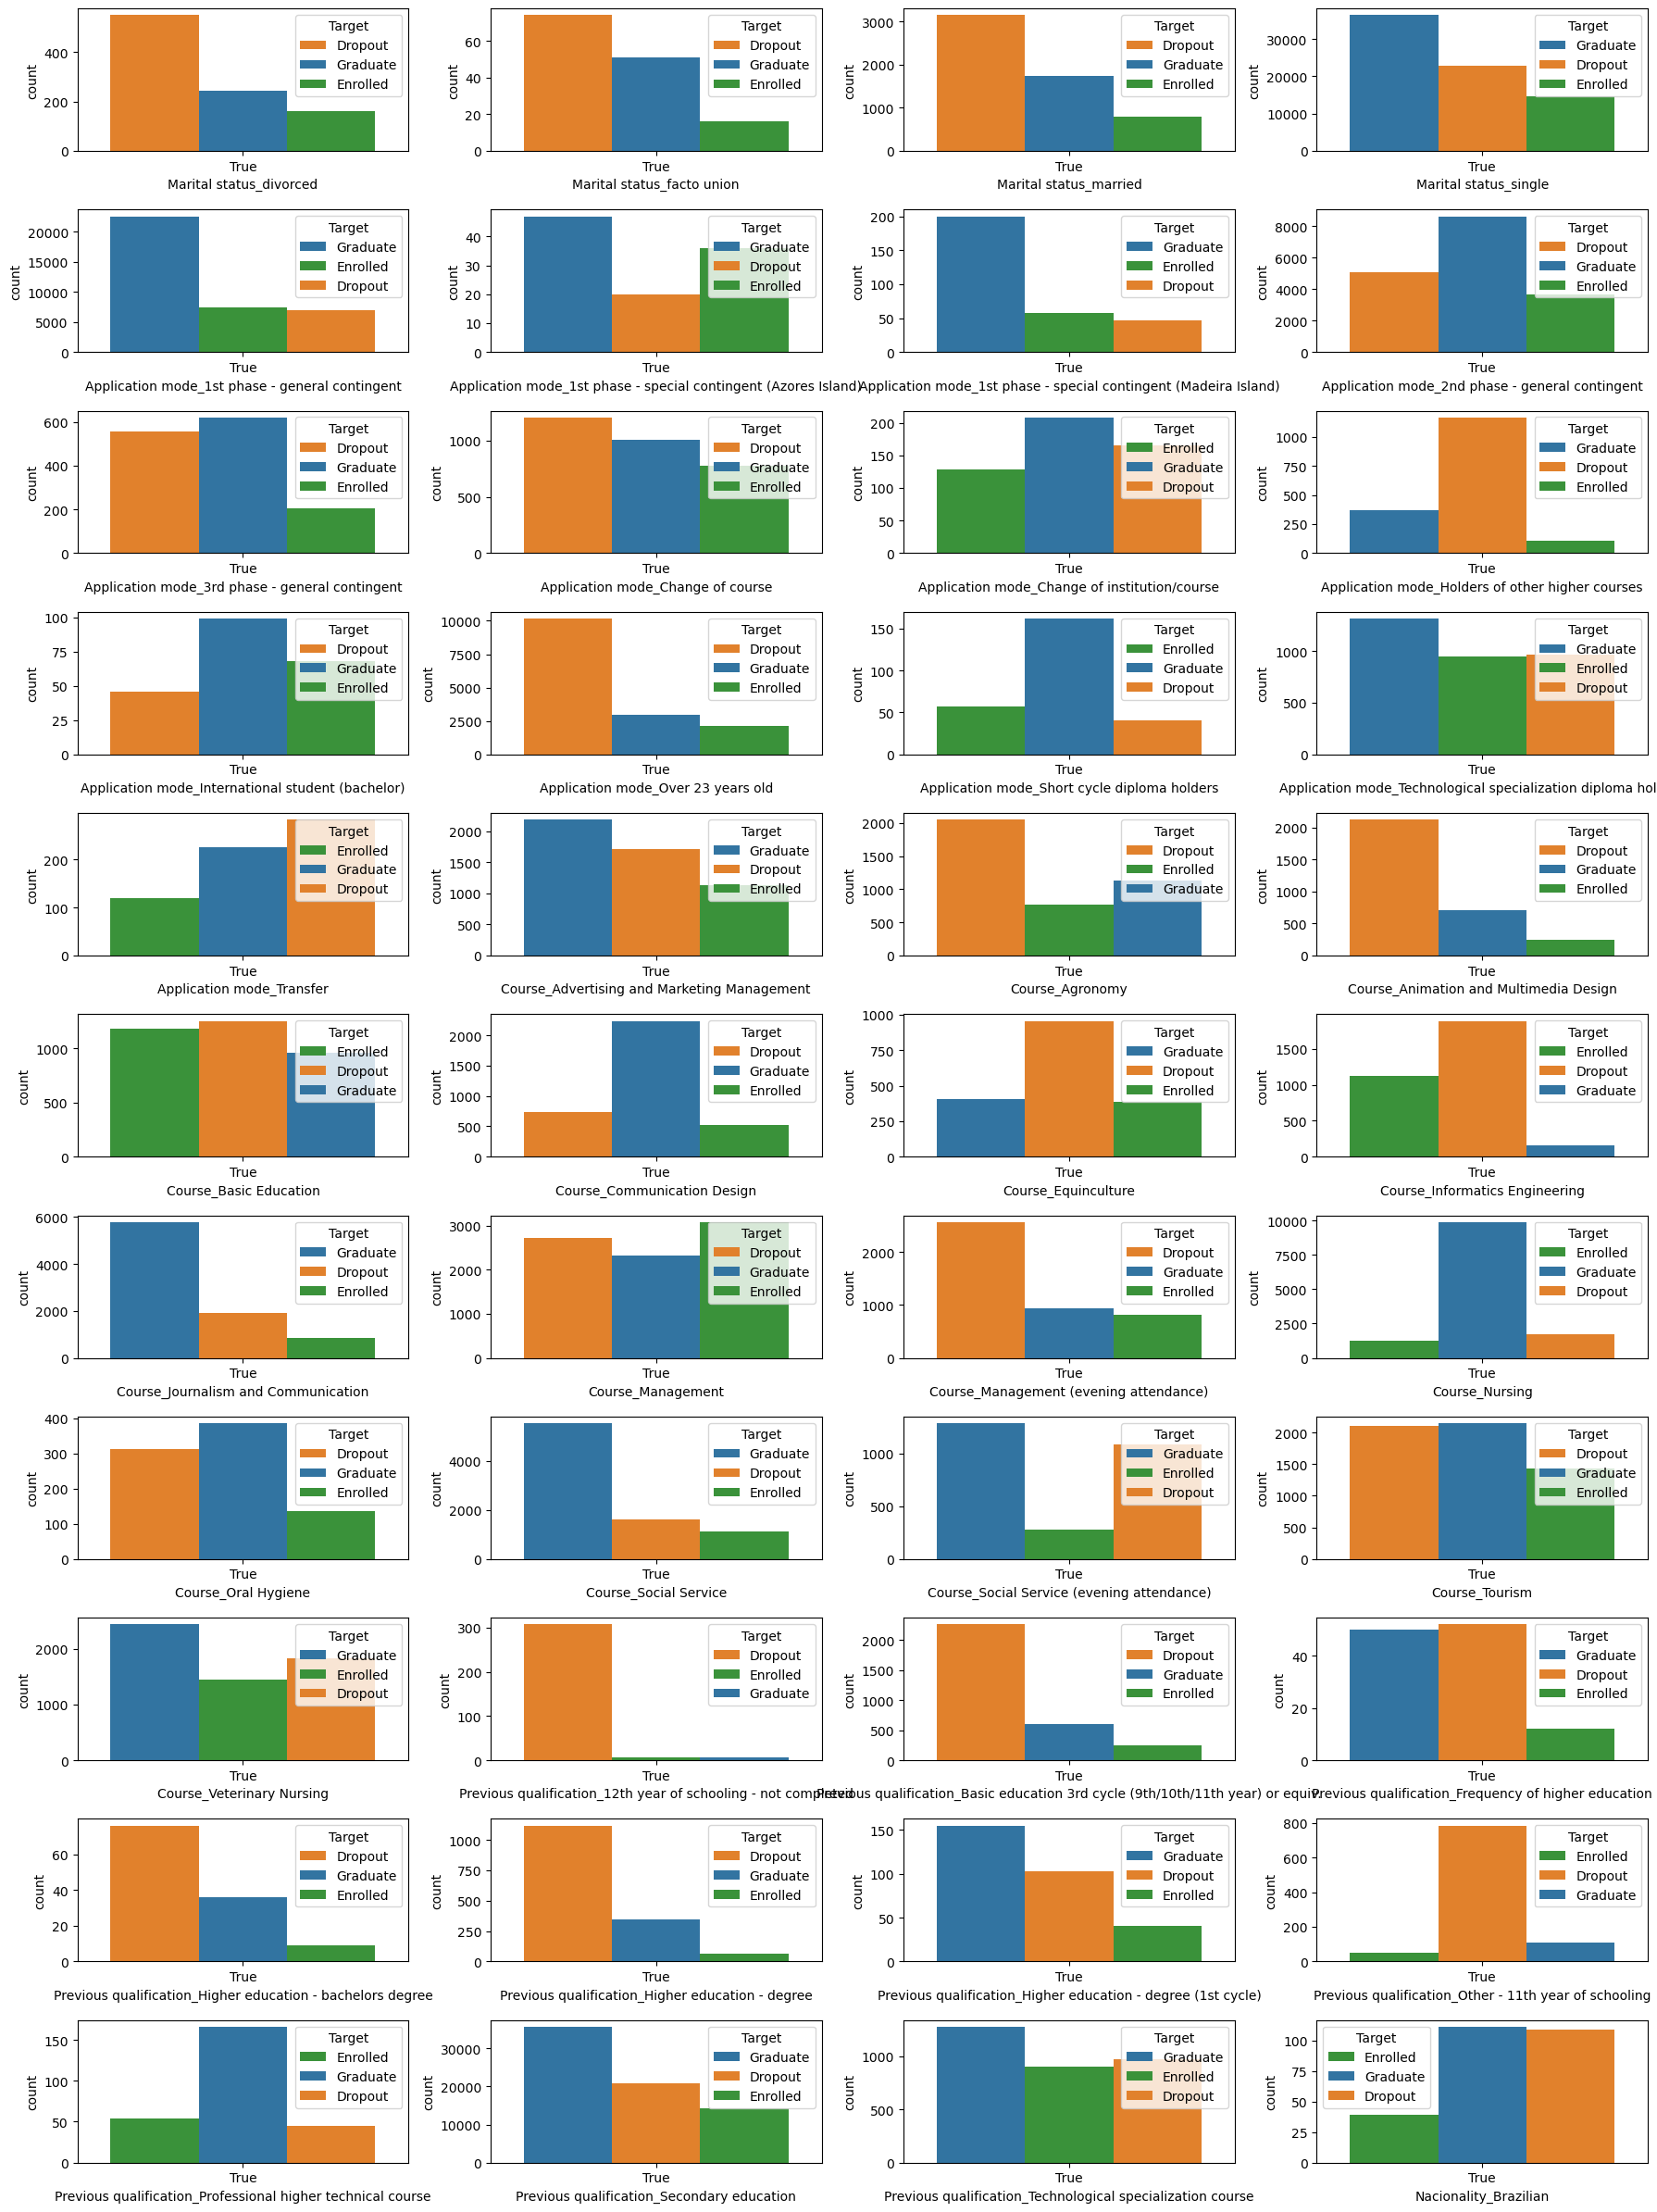

In [272]:
plt.figure(figsize=(18, 24))
plotnumber = 1

# Loop through each column
for col in ls[:44]:
    data = one_hot_encoded_data.loc[one_hot_encoded_data[col]==1, [col]].reset_index(drop=True)
    color = one_hot_encoded_data.loc[one_hot_encoded_data[col]==1, ['Target']].reset_index(drop=True)
    if plotnumber <= len(ls):
        plt.subplot(11, 4, plotnumber)
        ax = sns.countplot(x=data[col], hue=color['Target'],palette=palette)
        #ax.get_legend().remove()

    plotnumber += 1

#plt.suptitle('Distribution of Categorical Variables by Target', fontsize=40, y=1)
plt.tight_layout()
#plt.axis('off')

plt.show()


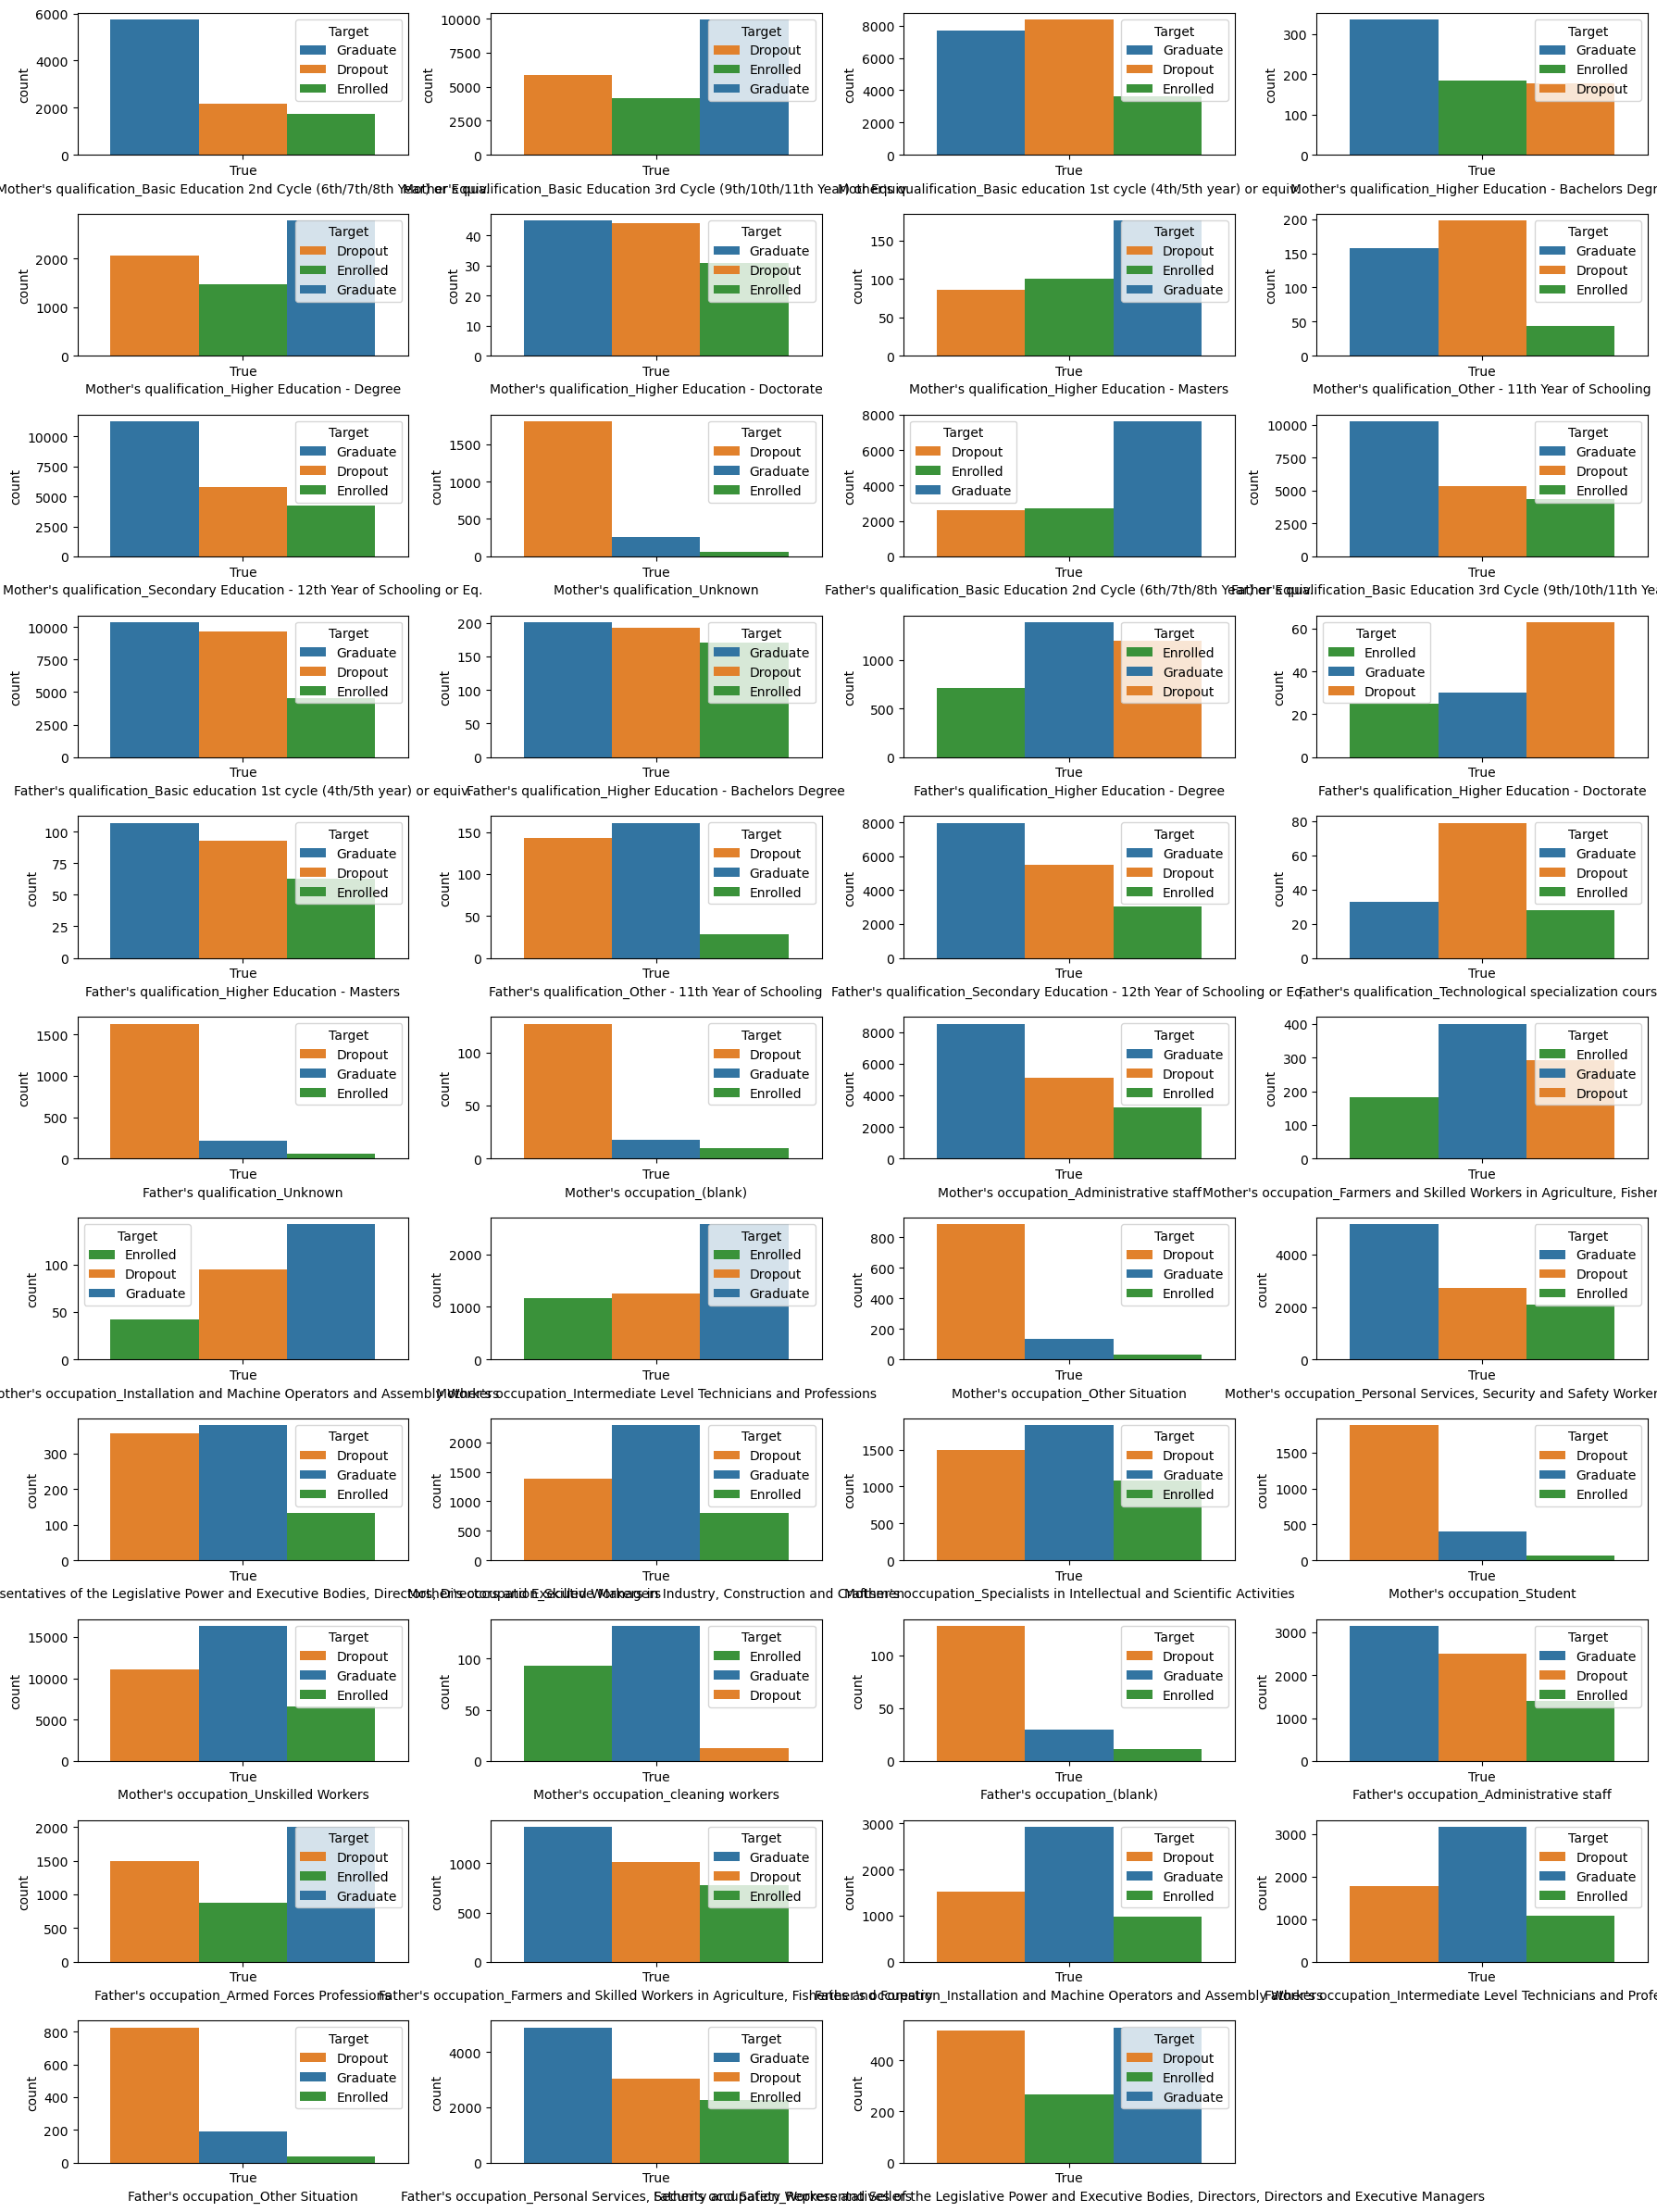

In [273]:
plt.figure(figsize=(18, 24))
plotnumber = 1

# Loop through each column
for col in ls[45:88]:
    data = one_hot_encoded_data.loc[one_hot_encoded_data[col]==1, [col]].reset_index(drop=True)
    color = one_hot_encoded_data.loc[one_hot_encoded_data[col]==1, ['Target']].reset_index(drop=True)
    if plotnumber <= len(ls):
        plt.subplot(11, 4, plotnumber)
        ax = sns.countplot(x=data[col], hue=color['Target'],palette=palette)
        #ax.get_legend().remove()

    plotnumber += 1

#plt.suptitle('Distribution of Categorical Variables by Target', fontsize=40, y=1)
plt.tight_layout()
#plt.axis('off')

plt.show()


In [274]:
for col in ls[45:88]:
    data = one_hot_encoded_data.loc[one_hot_encoded_data[col]==1, [col]].reset_index(drop=True)
    color = one_hot_encoded_data.loc[one_hot_encoded_data[col]==1, ['Target']].reset_index(drop=True)

In [275]:
enrolled = train[train['Target']=='Enrolled']
graduate = train[train['Target']=='Graduate']
dropout = train[train['Target']=='Dropout']

In [276]:
palette ={"Graduate": "C0", "Dropout": "C1", "Enrolled": "C2"}

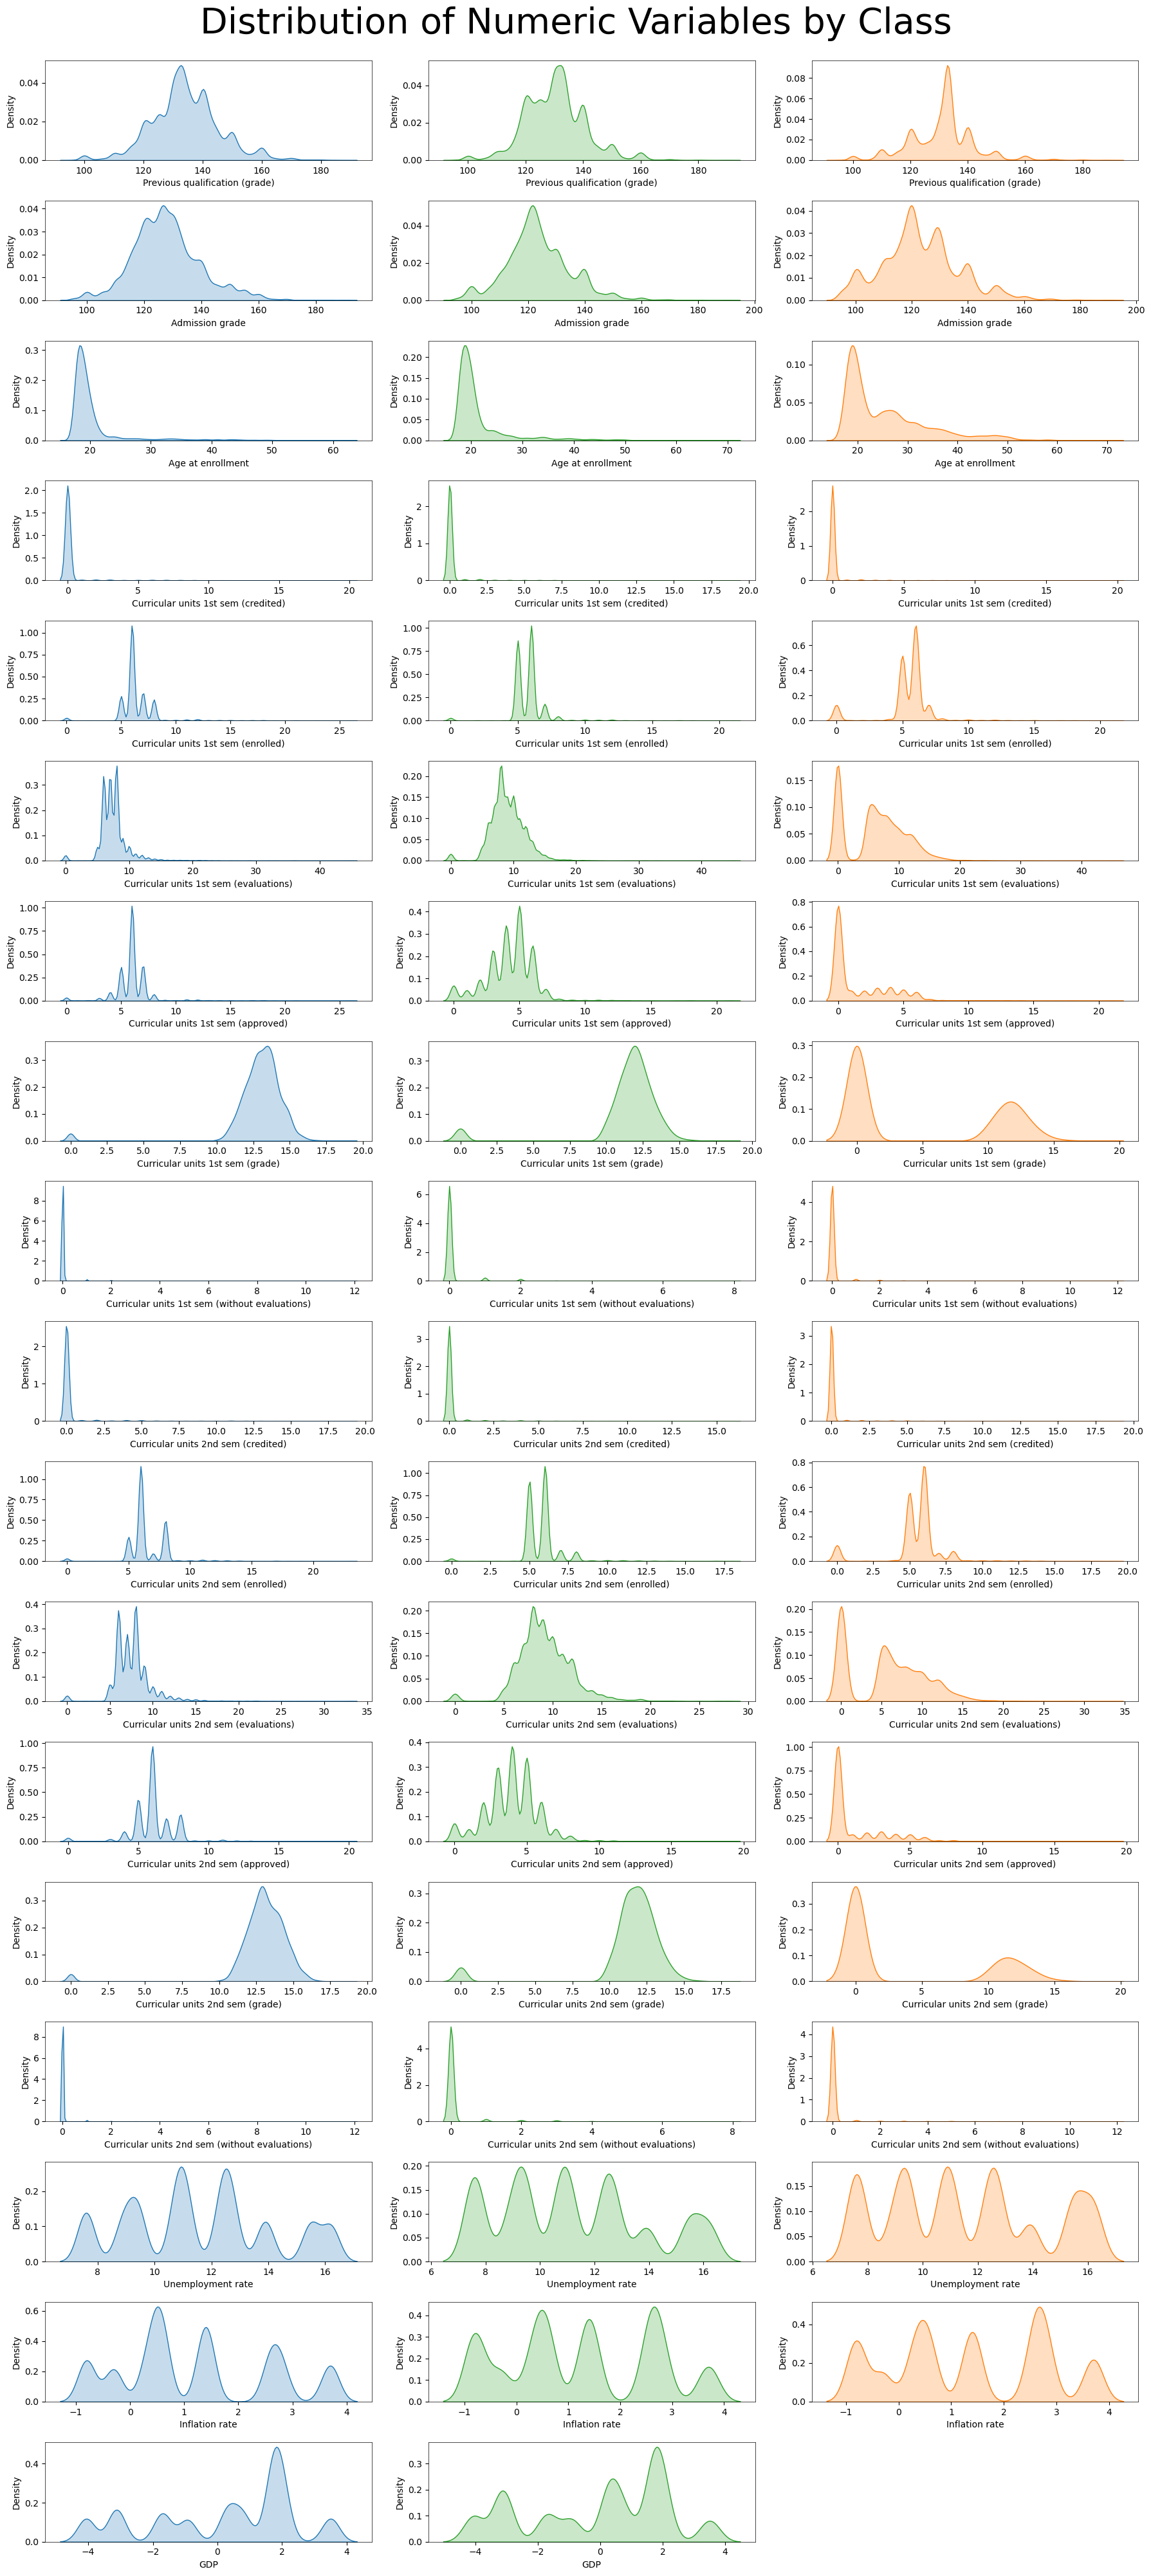

In [277]:
# Distribution of numeric variables by class
plt.figure(figsize=(18, 40))
plotnumber = 1

for column in num_cols:
    for x in ["Graduate", "Dropout", "Enrolled"]:
        if plotnumber <= len(num_cols)*3:
            if plotnumber in range(1, 54, 3):
                ax = plt.subplot(18, 3, plotnumber)
                sns.kdeplot(graduate[column], color='C0', fill=True)
                for spine in ax.spines.values():
                    spine.set_visible(True)
                    spine.set_color('black')
                    spine.set_linewidth(0.5)
                plt.xlabel(column)
                ax.grid(False)
            elif plotnumber in range(2, 54, 3):
                ax = plt.subplot(18, 3, plotnumber)
                sns.kdeplot(enrolled[column], color='C2', fill=True)
                for spine in ax.spines.values():
                    spine.set_visible(True)
                    spine.set_color('black')
                    spine.set_linewidth(0.5)
                plt.xlabel(column)
                ax.grid(False)
            elif plotnumber in range(3, 54, 3):
                ax = plt.subplot(18, 3, plotnumber)
                sns.kdeplot(dropout[column], color='C1', fill=True)
                for spine in ax.spines.values():
                    spine.set_visible(True)
                    spine.set_color('black')
                    spine.set_linewidth(0.5)
                plt.xlabel(column)
                ax.grid(False)


        
        plotnumber += 1

plt.suptitle('Distribution of Numeric Variables by Class', fontsize=40, y=1)
plt.tight_layout()
plt.show()

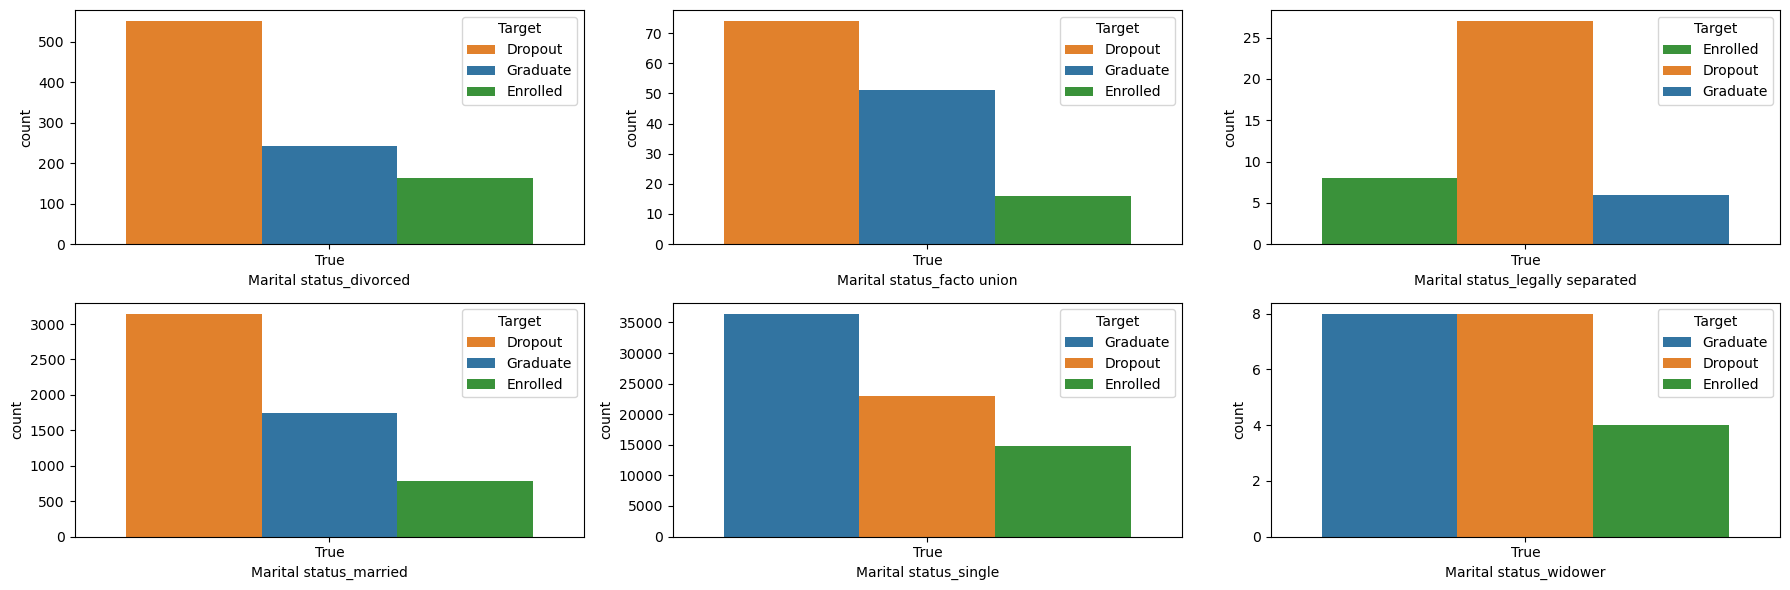

In [278]:
plt.figure(figsize=(18, 6))
plotnumber = 1

# Loop through each column
for col in dummy_vars[:6]:
    data = one_hot_encoded_data.loc[one_hot_encoded_data[col]==1, [col]].reset_index(drop=True)
    color = one_hot_encoded_data.loc[one_hot_encoded_data[col]==1, ['Target']].reset_index(drop=True)
    if plotnumber <= len(dummy_vars):
        plt.subplot(2, 3, plotnumber)
        ax = sns.countplot(x=data[col], hue=color['Target'],palette=palette)
        #ax.get_legend().remove()

    plotnumber += 1

#plt.suptitle('Distribution of Categorical Variables by Target', fontsize=40, y=1)
plt.tight_layout()
#plt.axis('off')

plt.show()

# Feature correlations


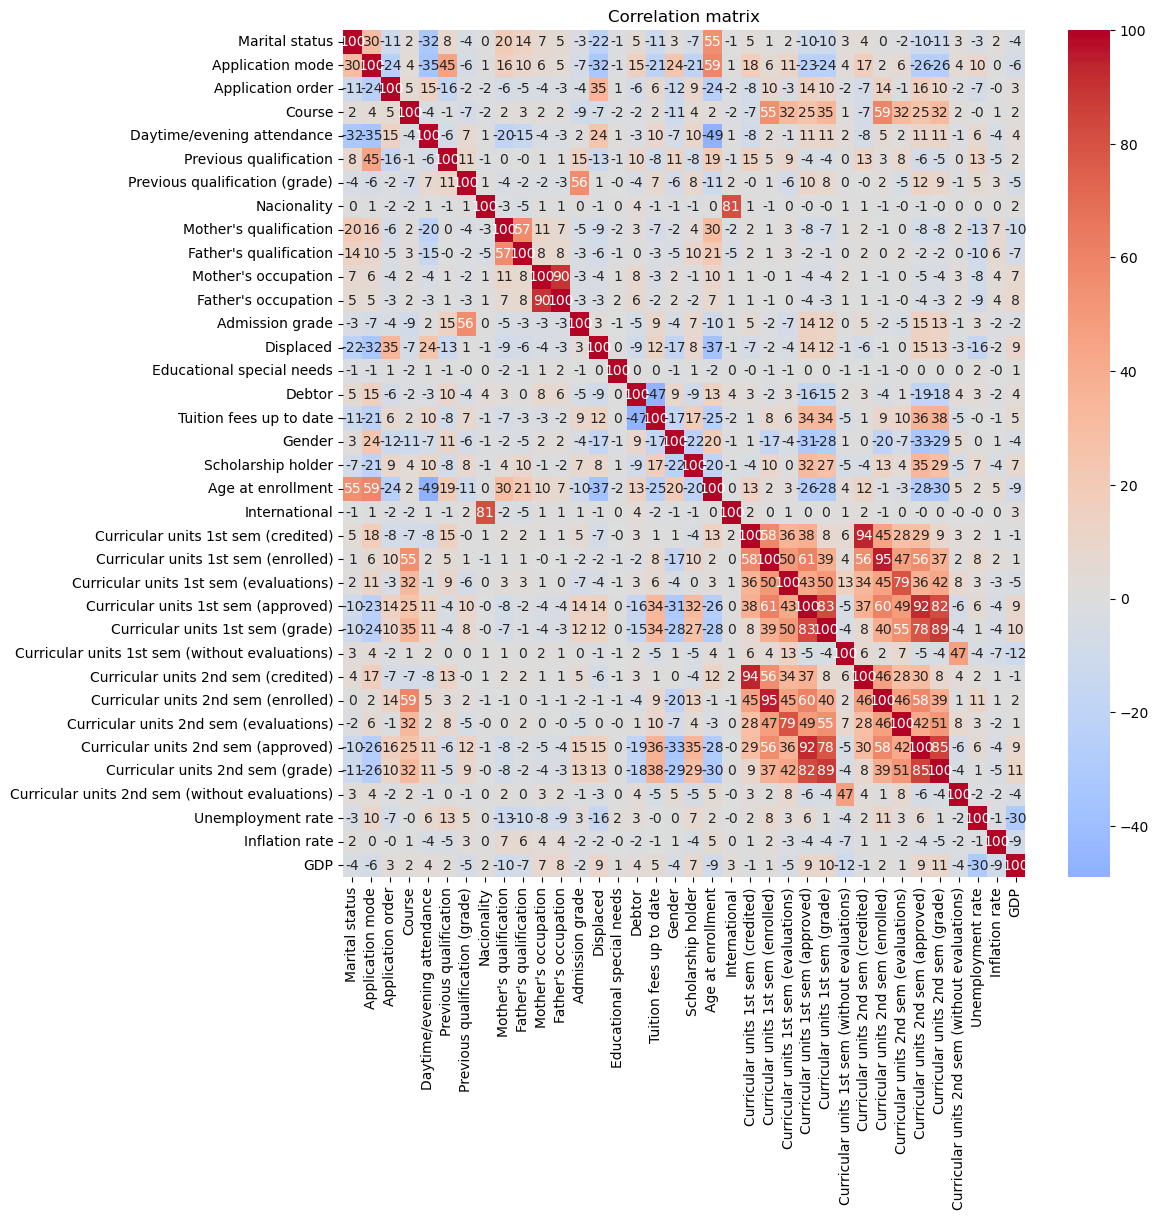

In [279]:
corr_features = initial_features
cc = np.corrcoef(train[initial_features], rowvar=False)


plt.figure(figsize=(11, 11))
sns.heatmap(cc*100, center=0, cmap='coolwarm', annot=True, fmt='.0f',
            xticklabels=corr_features, yticklabels=corr_features)
plt.title('Correlation matrix')
plt.show()

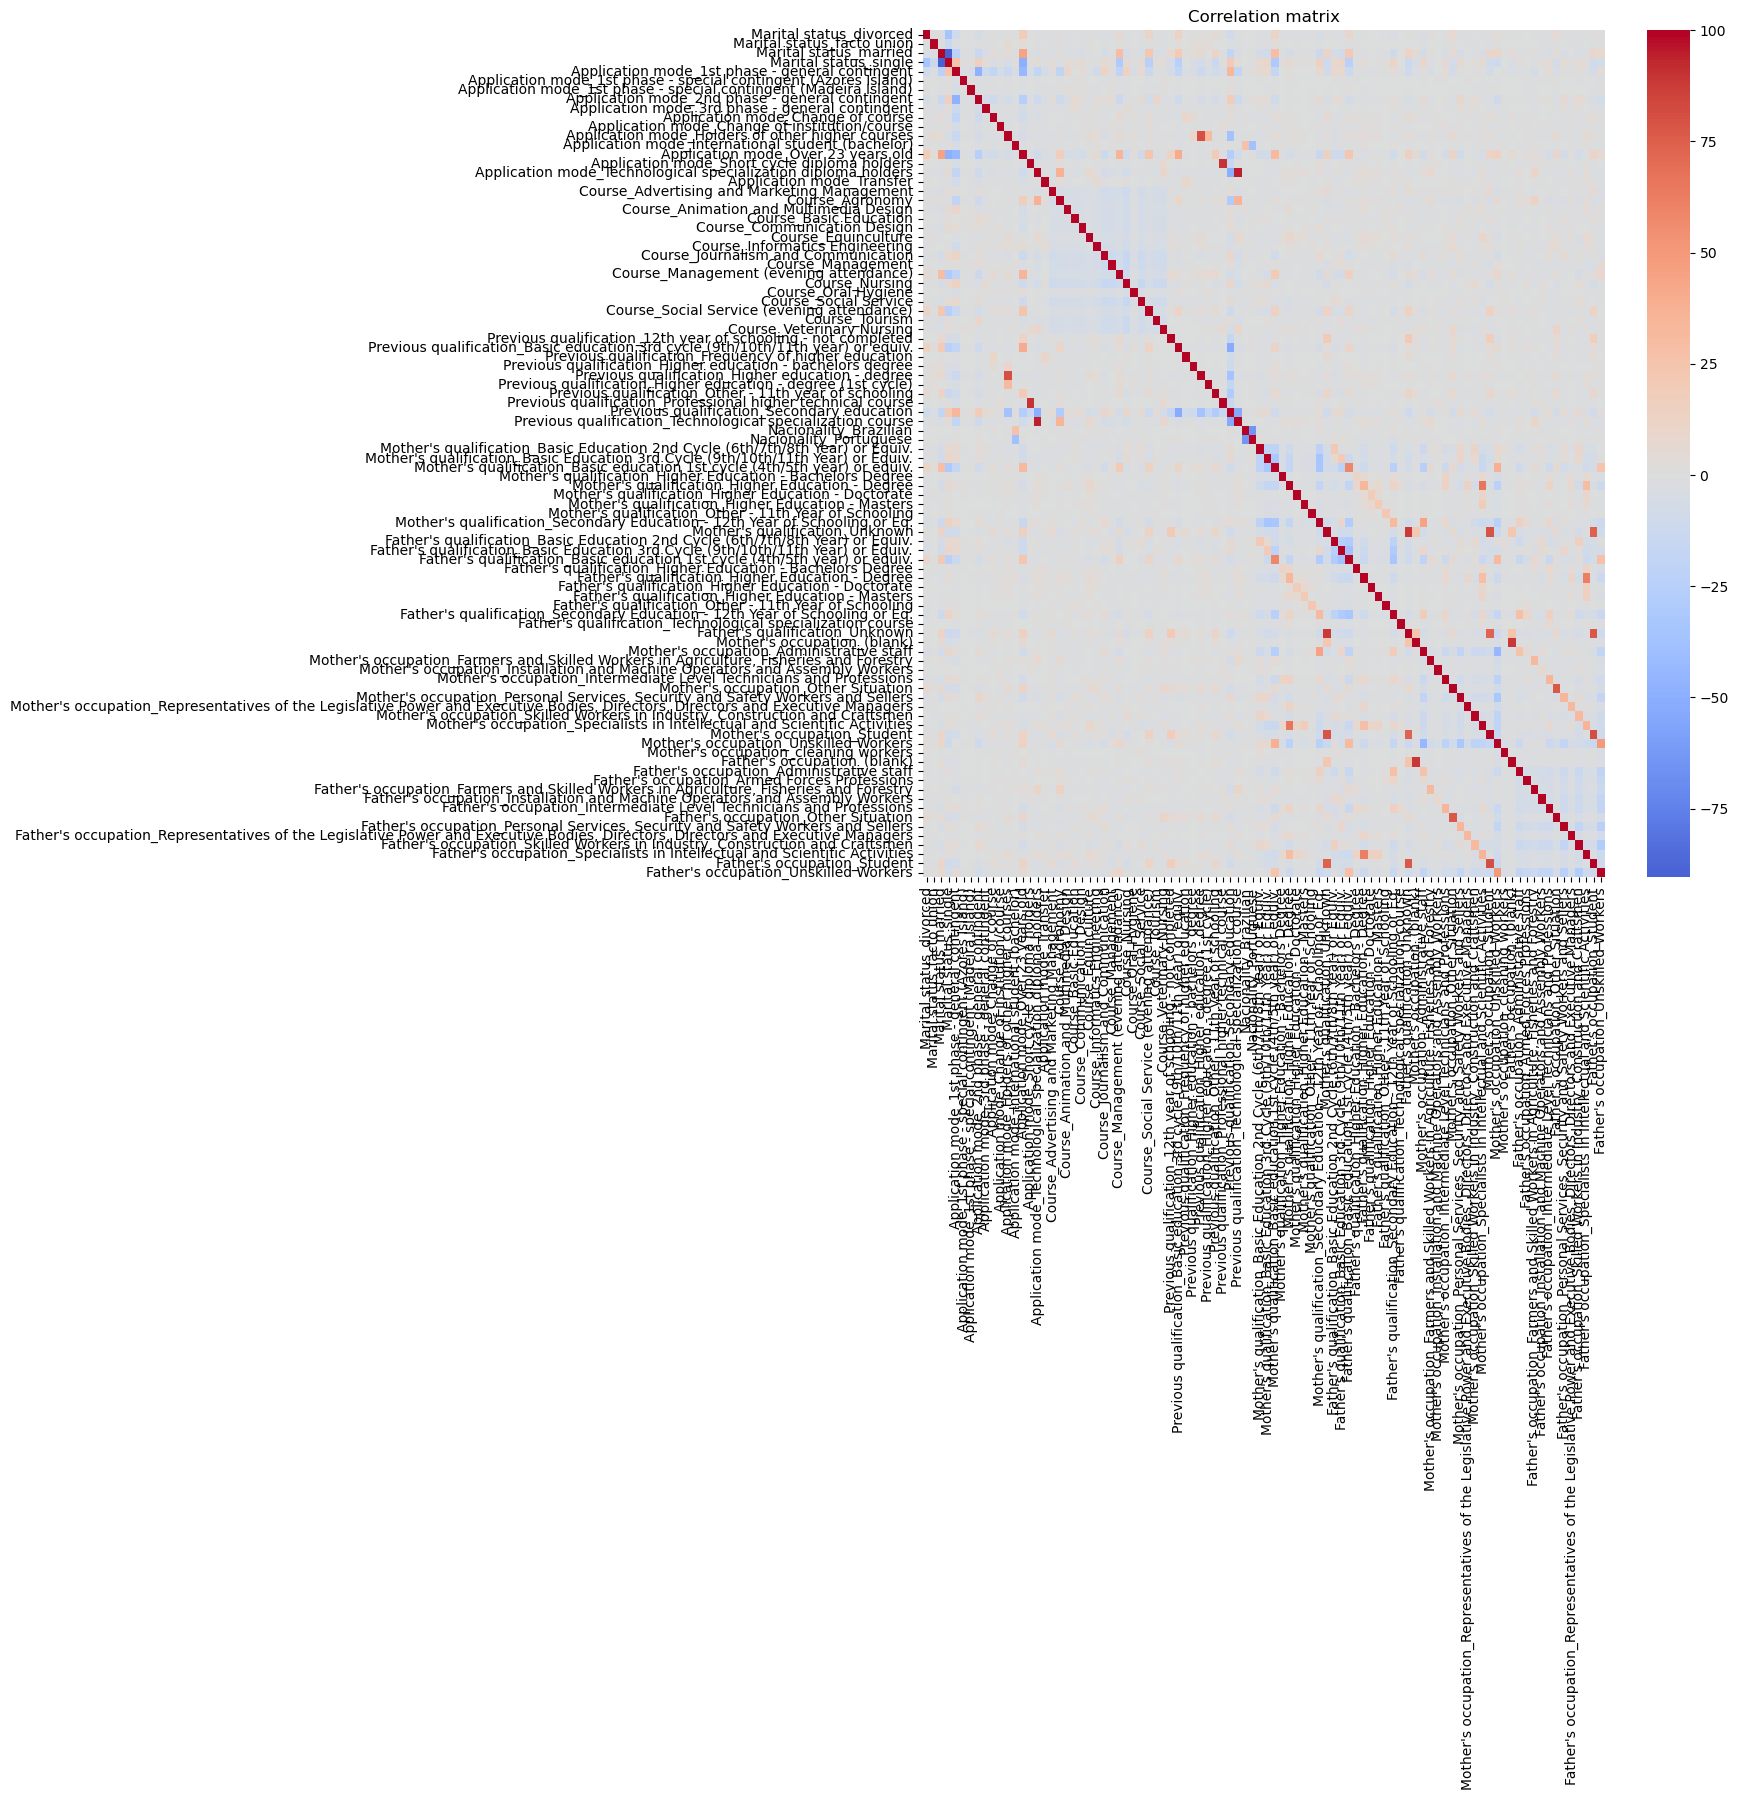

In [280]:
corr_features = ls
cc = np.corrcoef(one_hot_encoded_data[ls].astype(float), rowvar=False)


plt.figure(figsize=(11, 11))
sns.heatmap(cc*100, center=0, cmap='coolwarm', fmt='.0f',xticklabels=corr_features, yticklabels=corr_features)
plt.title('Correlation matrix')
plt.show()

# Comparing train, test and the original data


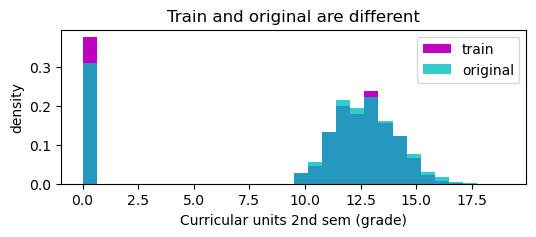

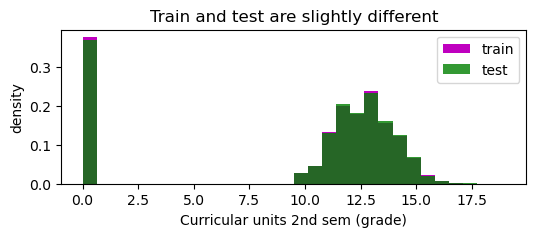

In [281]:
plt.figure(figsize=(6, 2))
plt.hist(train['Curricular units 2nd sem (grade)'],
         bins=np.linspace(0, 19, 31),
         density=True,
         color='m',
         label='train')
plt.hist(original['Curricular units 2nd sem (grade)'],
         bins=np.linspace(0, 19, 31),
         density=True,
         alpha=0.8,
         color='c',
         label='original')
plt.xlabel('Curricular units 2nd sem (grade)')
plt.ylabel('density')
plt.title('Train and original are different')
plt.legend()
plt.show()

plt.figure(figsize=(6, 2))
plt.hist(train['Curricular units 2nd sem (grade)'],
         bins=np.linspace(0, 19, 31),
         density=True,
         color='m',
         label='train')
plt.hist(test['Curricular units 2nd sem (grade)'],
         bins=np.linspace(0, 19, 31),
         density=True,
         alpha=0.8,
         color='g',
         label='test')
plt.xlabel('Curricular units 2nd sem (grade)')
plt.ylabel('density')
plt.title('Train and test are slightly different')
plt.legend()
plt.show()

[Mann–Whitney U test](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test)

In [282]:
print('Mann–Whitney U test comparing train and original datasets')
print(mannwhitneyu(train['Curricular units 2nd sem (grade)'],
                   original['Curricular units 2nd sem (grade)']))
print('\nMann–Whitney U test comparing train and test datasets')
print(mannwhitneyu(train['Curricular units 2nd sem (grade)'],
                   test['Curricular units 2nd sem (grade)']))


Mann–Whitney U test comparing train and original datasets
MannwhitneyuResult(statistic=170731302.5, pvalue=1.5728147659584625e-07)

Mann–Whitney U test comparing train and test datasets
MannwhitneyuResult(statistic=2057507531.0, pvalue=0.29560407920836107)


# The two most important features

A decision tree shows us the two most important predictive features:
- If `Curricular units 2nd sem (approved)` is 5 or more, the student will graduate at the end of the three-year course.
- If `Curricular units 2nd sem (approved)` is 0 or 1, the student will drop out before the end of the three-year course.
- Otherwise, check the tuition fees. If they are up to date, the student will be enrolled, but not yet graduated; if they are not, the student will drop out.

See [here](https://www.kaggle.com/competitions/playground-series-s4e6/discussion/509073) for a more thorough discussion.

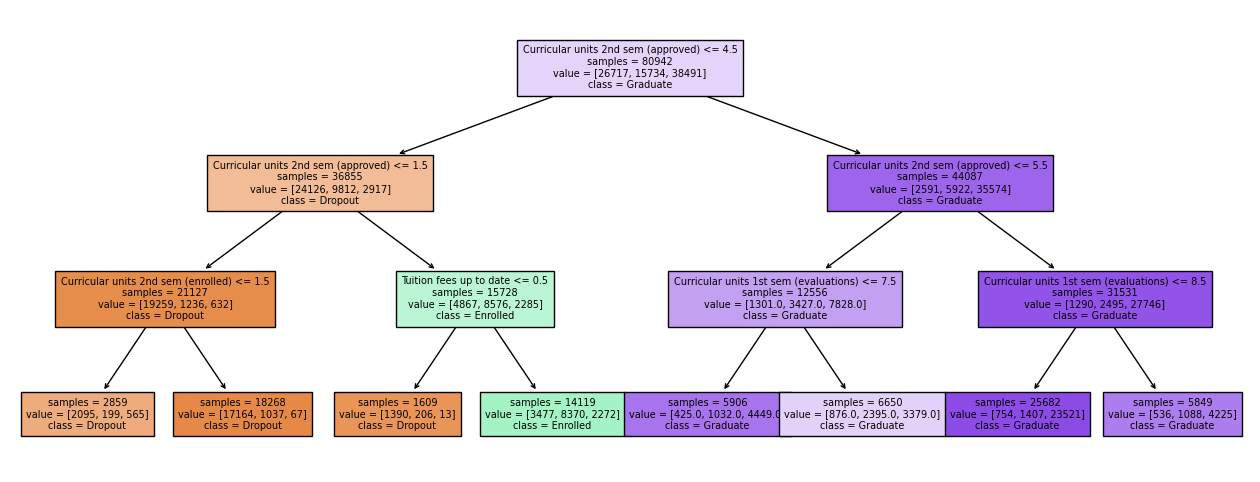

In [283]:
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(train[initial_features], train.Target);

plt.figure(figsize=(16, 6))
plot_tree(dt, feature_names=initial_features, class_names=label_encoder.classes_, fontsize=7, impurity=False, filled=True, ax=plt.gca())
plt.show()

# Base Model

In [284]:
model = xgb.XGBClassifier(enable_categorical=True,objective='multi:softprob', eval_metric= 'mlogloss')
# Overall: accuracy=0.83150 logloss=0.43800 XGBoost untuned   0 min

X = one_hot_encoded_data.drop(columns=['Target'])
y = targets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

predictions = (model.fit(X_train, y_train)).predict(X_test)

print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))

Accuracy score on testing data: 0.8335


# Tuning the Model

In [54]:
def modelfit(alg, X_train, y_train, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train, label=y_train)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='mlogloss', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X_train, y_train, eval_metric='mlogloss')
        
    #Predict training set:
    predictions = alg.predict(X_train)
    predprob = alg.predict_proba(X_train)
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % accuracy_score(y_train, predictions))
    print("Log loss: ", log_loss(y_train, predprob))
                    
    feat_imp = pd.Series(alg.feature_importances_).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [55]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 num_class=3,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'multi:softmax',
 nthread=4,
 scale_pos_weight=2,
 seed=27)

C:\Users\chade\anaconda3\envs\classification\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:02:07] WARNING: C:\b\abs_0fh_d4x2ng\croot\xgboost-split_1713973188995\work\cpp_src\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\chade\anaconda3\envs\classification\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\chade\anaconda3\envs\classification\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:03:16] WARNING: C:\b\abs_0fh_d4x2ng\croot\xgboost-split_1713973188995\work\cpp_src\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)



Model Report
Accuracy : 0.8583
Log loss:  0.3672344025478896


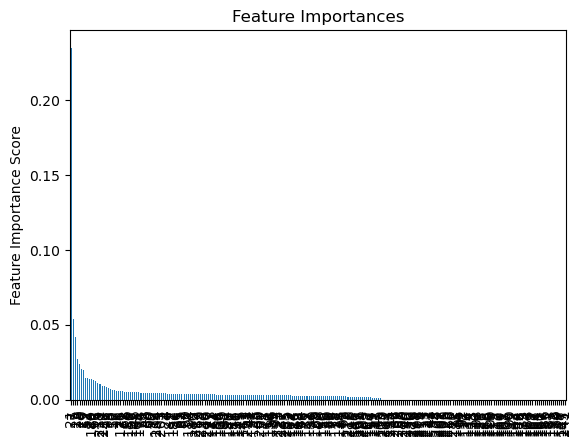

In [56]:
modelfit(xgb1, X_train, y_train)

In [58]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=242, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softmax', nthread=4, seed=27, enable_categorical=True, num_class=3), 
 param_grid = param_test1, scoring= 'neg_log_loss',n_jobs=4, cv=5)
gsearch1.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=True, eval_metric=None,
                                     feature_types=None, gamma=0,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=5,
                                     max_leaves=None, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=242,
                                     n_jobs=None, nthread=4, num_class=3, ...),
             n_jobs=4,
             param_grid={'max_depth': range(3, 10, 2),
                         'min_child_weight': range(1, 6, 2)},
             scoring='neg_log_loss')

In [59]:
#gsearch1.cv_results_, 
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 5, 'min_child_weight': 5}, -0.43467616941870285)

In [60]:
param_test2b = {
 'min_child_weight':[6,8,10,12]
}
gsearch2b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=242, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softmax', nthread=4,seed=27,enable_categorical=True, num_class=3), 
 param_grid = param_test2b, scoring='neg_log_loss',n_jobs=4, cv=5)
gsearch2b.fit(X_train,y_train)
gsearch2b.fit(X_train,y_train)
#gsearch2b.cv_results_, 
gsearch2b.best_params_, gsearch2b.best_score_

({'min_child_weight': 6}, -0.43460654534251664)

In [61]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=242, max_depth=5,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softmax', nthread=4,seed=27,enable_categorical=True, num_class=3), 
 param_grid = param_test3, scoring='neg_log_loss',n_jobs=4, cv=5)
gsearch3.fit(X_train,y_train)
#gsearch3.cv_results_, 
gsearch3.best_params_, gsearch3.best_score_

({'gamma': 0.0}, -0.43467616941870285)

In [62]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=242, max_depth=5,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softmax', nthread=4,seed=27,enable_categorical=True, num_class=3), 
 param_grid = param_test4, scoring='neg_log_loss',n_jobs=4, cv=5)
gsearch4.fit(X_train,y_train)
#gsearch4.cv_results_, 
gsearch4.best_params_, gsearch4.best_score_

({'colsample_bytree': 0.6, 'subsample': 0.7}, -0.4343192973945139)

In [63]:
#gsearch4.cv_results_, 
gsearch4.best_params_, gsearch4.best_score_

({'colsample_bytree': 0.6, 'subsample': 0.7}, -0.4343192973945139)

In [64]:
param_test5 = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(55,70,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=242, max_depth=5,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softmax', nthread=4, seed=27,enable_categorical=True, num_class=3), 
 param_grid = param_test5, scoring='neg_log_loss',n_jobs=4, cv=5)
gsearch5.fit(X_train,y_train)
#gsearch5.cv_results_, 
gsearch5.best_params_, gsearch5.best_score_

({'colsample_bytree': 0.6, 'subsample': 0.75}, -0.43432263263930376)

In [65]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=242, max_depth=5,
 min_child_weight=5, gamma=0.1, subsample=0.85, colsample_bytree=0.55,
 objective= 'multi:softmax', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='neg_log_loss',n_jobs=4, cv=5)
gsearch6.fit(X_train,y_train)
#gsearch6.cv_results_, 
gsearch6.best_params_, gsearch6.best_score_

C:\Users\chade\anaconda3\envs\classification\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:34:31] WARNING: C:\b\abs_0fh_d4x2ng\croot\xgboost-split_1713973188995\work\cpp_src\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


({'reg_alpha': 0.01}, -0.4342082103396726)

In [66]:
param_test7 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=242, max_depth=5,
 min_child_weight=5, gamma=0.1, subsample=0.85, colsample_bytree=0.55,
 objective= 'multi:softmax', nthread=4,seed=27), 
 param_grid = param_test7, scoring='neg_log_loss',n_jobs=4, cv=5)
gsearch7.fit(X_train,y_train)
#gsearch7.cv_results_, 
gsearch7.best_params_, gsearch7.best_score_

({'reg_alpha': 0.01}, -0.4342082103396726)

C:\Users\chade\anaconda3\envs\classification\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



Model Report
Accuracy : 0.8597
Log loss:  0.36691871580748103


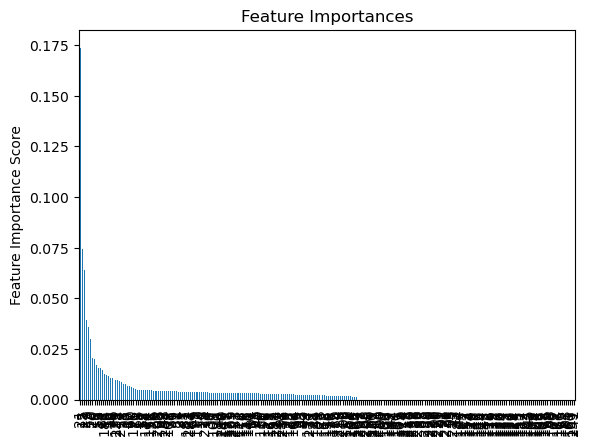

In [67]:
xgb4 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=5,
 min_child_weight=5,
 gamma=0,
 subsample=0.85,
 colsample_bytree=0.55,
 reg_alpha=0.01,
 objective= 'multi:softmax',
 enable_categorical= True,
 num_class=3,
 nthread=4,
 seed=27)
modelfit(xgb4, X_train, y_train)

In [68]:
predictions = xgb4.predict(X_test)

print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))

Accuracy score on testing data: 0.8365


In [69]:
predprob = xgb4.predict_proba(X_test)
print("Log loss: ", log_loss(y_test, predprob))

Log loss:  0.42351126813426637


In [73]:
param_test8 = {
 'scale_pos_weight':[0.5, 1, 1.5, 2]
}
gsearch8 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=242, max_depth=5,
 min_child_weight=5, gamma=0.1, subsample=0.85, colsample_bytree=0.55,
 objective= 'multi:softmax', nthread=4,seed=27), 
 param_grid = param_test8, scoring='neg_log_loss',n_jobs=4, cv=5)
gsearch8.fit(X_train,y_train)
#gsearch8.cv_results_, 
gsearch8.best_params_, gsearch7.best_score_

C:\Users\chade\anaconda3\envs\classification\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:50:28] WARNING: C:\b\abs_0fh_d4x2ng\croot\xgboost-split_1713973188995\work\cpp_src\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


({'scale_pos_weight': 0.5}, -0.4342082103396726)

# Binary Classification

In [285]:
binary = train.copy()

In [286]:
binary = binary[binary.Target != 'Dropout']

In [287]:
_binary = binary.copy()

for col in multi_cat:
    #print(col)
    _binary[col] = _binary[col].map(eval(data_dic.loc[data_dic['Variable Name']==col, ['Description']].values.tolist()[0][0]))

bbinary = pd.get_dummies(_binary, columns = multi_cat)

In [288]:
bbinary = bbinary[ls+bi_cat+num_cols+['Target']]

In [289]:
X = bbinary.drop(columns=['Target'])
y = _binary.Target
label_encoder2 = LabelEncoder()
btargets = label_encoder2.fit_transform(y)
bx_train, bx_test, by_train, by_test = train_test_split(X, btargets, test_size=0.2, random_state=42)

In [290]:
by_test.shape

(10845,)

In [291]:
bmodel = xgb.XGBClassifier(enable_categorical=True,objective='binary:logistic', eval_metric= 'logloss')

b_pred = (bmodel.fit(bx_train, by_train)).predict(bx_test)

print("Accuracy score on testing data: {:.4f}".format(accuracy_score(by_test, b_pred)))

Accuracy score on testing data: 0.8742


In [292]:
bcheck = pd.concat([pd.Series(by_test,name='Actual'),pd.Series(b_pred,name='Predictions')], axis=1)
bcheck['Correct'] = bcheck.Actual == bcheck.Predictions

In [293]:
bcheck[bcheck.Actual==0].Correct.sum()/bcheck[bcheck.Actual==0].shape[0]

0.7297906602254428

In [294]:
bcheck[bcheck.Actual==1].Correct.sum()/bcheck[bcheck.Actual==1].shape[0]

0.9321705426356589

In [295]:
binary_y = X_test.copy()

# Final Model for Scoring Test File

In [296]:
X_train2= X_train[ls+bi_cat+num_cols]

C:\Users\chade\anaconda3\envs\classification\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:30:05] WARNING: C:\b\abs_0fh_d4x2ng\croot\xgboost-split_1713973188995\work\cpp_src\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\chade\anaconda3\envs\classification\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:30:06] WARNING: C:\b\abs_0fh_d4x2ng\croot\xgboost-split_1713973188995\work\cpp_src\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\chade\anaconda3\envs\classification\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\chade\anaconda3\envs\classification\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:36:35] WARNING: C:\b\abs_0fh_d4x2ng\croot\xgboost-split_1


Model Report
Accuracy : 0.8618
Log loss:  0.3623426489958477


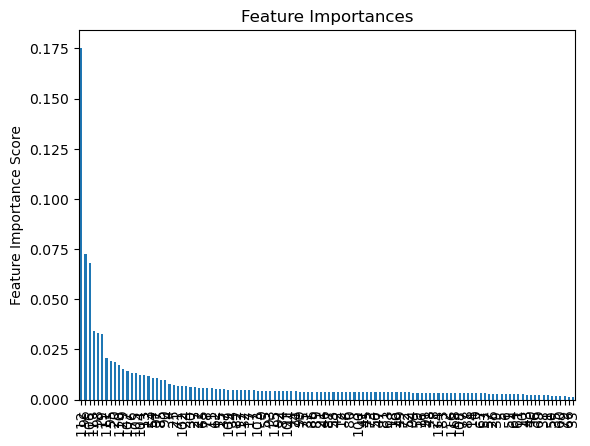

In [297]:
xgb5 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=5,
 min_child_weight=5,
 gamma=0,
 subsample=0.85,
 colsample_bytree=0.55,
 reg_alpha=0.01,
 objective= 'multi:softmax',
 enable_categorical= True,
 num_class=3,
 nthread=4,
 seed=27,
scale_pos_weight=1)
modelfit(xgb5, X_train2, y_train)

In [298]:
X_test2= X_test[ls+bi_cat+num_cols]

In [299]:
predictions = xgb5.predict(X_test2)

print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))

Accuracy score on testing data: 0.8382


In [300]:
predprob = xgb5.predict_proba(X_test2)
print("Log loss: ", log_loss(y_test, predprob))

Log loss:  0.4238860262579891


In [301]:
b_preds = bmodel.predict(X_test2)

y1 = label_encoder.inverse_transform(predictions)

y2 = label_encoder2.inverse_transform(b_preds)

combine = pd.concat([pd.Series(y1,name='y1'),pd.Series(y2,name='y2')], axis=1)
combine['equal'] = combine.y1 == combine.y2

combine.loc[y1 != 'Dropout',['y1']] = combine.loc[y1 != 'Dropout',['y2']].values

final_preds = label_encoder.transform(combine.y1)

In [302]:
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, final_preds)))

Accuracy score on testing data: 0.8560


In [303]:
check[check.Actual==2].shape[0]

NameError: name 'check' is not defined

In [ ]:
check = pd.concat([pd.Series(y_test,name='Actual'),pd.Series(predictions,name='Predictions')], axis=1)
check['Correct'] = check.Actual == check.Predictions

In [ ]:
y_test.shape

In [ ]:
check[check.Actual==2].shape[0]

In [ ]:
check[check.Actual==2].Correct.sum()/check[check.Actual==2].shape[0]

In [ ]:
check[check.Actual==1].Correct.sum()/check[check.Actual==1].shape[0]

In [ ]:
check[check.Actual==0].Correct.sum()/check[check.Actual==0].shape[0]

In [ ]:
predictions

In [ ]:
label_encoder.inverse_transform(predictions)

In [ ]:
len(xgb4.feature_names_in_)

In [ ]:
# Format
#id,Target
#76518,Graduate
#76519,Graduate
#76520,Graduate
#etc.

In [304]:
ttest = test.copy()

for col in multi_cat:
    #print(col)
    ttest[col] = ttest[col].map(eval(data_dic.loc[data_dic['Variable Name']==col, ['Description']].values.tolist()[0][0]))

ftest = pd.get_dummies(ttest, columns = multi_cat)

In [305]:
test2= ftest[ls+bi_cat+num_cols]

In [306]:
predictions = xgb5.predict(test2)


In [307]:
b_preds = bmodel.predict(test2)

y1 = label_encoder.inverse_transform(predictions)

y2 = label_encoder2.inverse_transform(b_preds)

combine = pd.concat([pd.Series(y1,name='y1'),pd.Series(y2,name='y2')], axis=1)
combine['equal'] = combine.y1 == combine.y2


In [308]:
(combine.loc[y1 != 'Dropout'].equal == False).sum()

1183

In [309]:

combine.loc[y1 != 'Dropout',['y1']] = combine.loc[y1 != 'Dropout',['y2']].values

final_preds = combine.y1.values

In [310]:
combine['equal'] = combine.y1 == combine.y2


In [311]:
(combine.loc[y1 != 'Dropout'].equal == False).sum()

0

In [312]:
combine

y1        y2  equal
0       Dropout  Graduate  False
1      Graduate  Graduate   True
2      Graduate  Graduate   True
3      Graduate  Graduate   True
4      Enrolled  Enrolled   True
...         ...       ...    ...
51007   Dropout  Graduate  False
51008   Dropout  Enrolled  False
51009   Dropout  Graduate  False
51010   Dropout  Enrolled  False
51011   Dropout  Graduate  False

[51012 rows x 3 columns]

In [313]:
final_preds

array(['Dropout', 'Graduate', 'Graduate', ..., 'Dropout', 'Dropout',
       'Dropout'], dtype=object)

In [314]:
#pred = label_encoder.inverse_transform(predictions)
sub = pd.Series(final_preds, index=test.index, name='Target')
filename = 'combined_model3.csv'

In [315]:
sub

id
76518      Dropout
76519     Graduate
76520     Graduate
76521     Graduate
76522     Enrolled
            ...   
127525     Dropout
127526     Dropout
127527     Dropout
127528     Dropout
127529     Dropout
Name: Target, Length: 51012, dtype: object

In [316]:
sub.to_csv(filename)

# Create Initial File for Submission